In [ ]:
####################################################################################################################
# Code is based on the following documentation:
#===================================================================================================================
# https://docs.python.org/3.11/library/os.html
# https://matplotlib.org/
# https://www.tensorflow.org/
# https://keras.io/
# https://pandas.pydata.org/
# https://pillow.readthedocs.io/en/stable/
# https://seaborn.pydata.org/index.html
# https://pyyaml.org/wiki/PyYAMLDocumentation
# https://tqdm.github.io/
# https://plotly.com/
# https://arrow.apache.org/docs/python/
####################################################################################################################

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pandas as pd
from PIL import Image
import seaborn as sns
import yaml
from tqdm.notebook import trange, tqdm
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, VGG19, VGG16, EfficientNetB0, EfficientNetV2B0, EfficientNetV2L, DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.layers import RandomRotation, RandomZoom, RandomFlip, Input, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

Create necessary directories

In [2]:
def create_directories():
    directories = ['models', 'metrics', 'architecture']
    
    for directory in directories:
        if not os.path.exists(directory):
            os.makedirs(directory)
            print(f"Directory '{directory}' created.")
        else:
            print(f"Directory '{directory}' already exists.")

create_directories()

Directory 'models' already exists.
Directory 'metrics' already exists.
Directory 'architecture' already exists.


Objective of this code is to classify provided image dataset into respective categories. The images contain objects which needs to be classified into appropriate class.

In [3]:
#DATASET_PATH = '/kaggle/input/image-net/Image_set/'
DATASET_PATH = 'Image_set'

# EDA

The following code reads the image files located in the `image-set` directory and generate a scatter plot based on the height and width dimensions of these images. This visualization will help us understand the variation in image dimensions within our dataset.

Upon examining the resulting plot, it becomes clear that the images in our dataset exhibit a significant range of sizes. However, it's notable that the majority of images in both the training and validation sets have dimensions approximately under 1000 pixels both height and width wise.

Processing train:   0%|          | 0/10 [00:00<?, ?it/s]

Processing images in n01440764 - train:   0%|          | 0/963 [00:00<?, ?it/s]

Processing images in n02102040 - train:   0%|          | 0/955 [00:00<?, ?it/s]

Processing images in n02979186 - train:   0%|          | 0/993 [00:00<?, ?it/s]

Processing images in n03000684 - train:   0%|          | 0/858 [00:00<?, ?it/s]

Processing images in n03028079 - train:   0%|          | 0/941 [00:00<?, ?it/s]

Processing images in n03394916 - train:   0%|          | 0/956 [00:00<?, ?it/s]

Processing images in n03417042 - train:   0%|          | 0/961 [00:00<?, ?it/s]

Processing images in n03425413 - train:   0%|          | 0/931 [00:00<?, ?it/s]

Processing images in n03445777 - train:   0%|          | 0/951 [00:00<?, ?it/s]

Processing images in n03888257 - train:   0%|          | 0/960 [00:00<?, ?it/s]

Processing val:   0%|          | 0/10 [00:00<?, ?it/s]

Processing images in n01440764 - val:   0%|          | 0/387 [00:00<?, ?it/s]

Processing images in n02102040 - val:   0%|          | 0/395 [00:00<?, ?it/s]

Processing images in n02979186 - val:   0%|          | 0/357 [00:00<?, ?it/s]

Processing images in n03000684 - val:   0%|          | 0/386 [00:00<?, ?it/s]

Processing images in n03028079 - val:   0%|          | 0/409 [00:00<?, ?it/s]

Processing images in n03394916 - val:   0%|          | 0/394 [00:00<?, ?it/s]

Processing images in n03417042 - val:   0%|          | 0/389 [00:00<?, ?it/s]

Processing images in n03425413 - val:   0%|          | 0/419 [00:00<?, ?it/s]

Processing images in n03445777 - val:   0%|          | 0/399 [00:00<?, ?it/s]

Processing images in n03888257 - val:   0%|          | 0/390 [00:00<?, ?it/s]

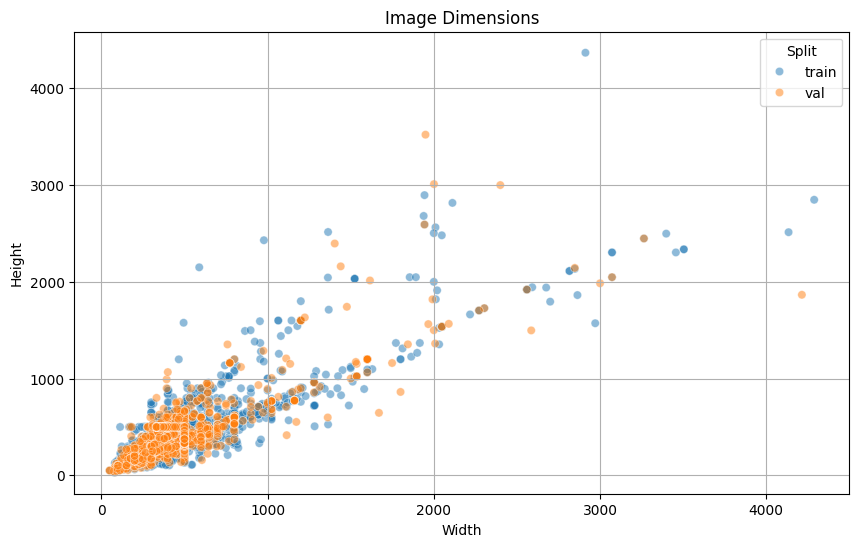

In [4]:
def plot_image_dimensions(image_dir):
    """
    Plot the dimensions (width and height) of images in the given directory.

    Args:
    image_dir (str): The directory containing the images.

    Returns:
    pandas.DataFrame: DataFrame containing image dimensions and paths.
    """
    image_sizes = []
    
    for split in ['train', 'val']:
        split_dir = os.path.join(image_dir, split)
        categories = [category for category in os.listdir(split_dir) if not category.startswith('.')]
        
        for category in tqdm(categories, desc=f'Processing {split}'):
            category_dir = os.path.join(split_dir, category)
            images = [image for image in os.listdir(category_dir) if not image.startswith('.')]
            
            for image_file in tqdm(images, desc=f'Processing images in {category} - {split}'):
                image_path = os.path.join(category_dir, image_file)
                
                with Image.open(image_path) as img:
                    width, height = img.size
                    image_sizes.append((width, height, split, category, image_path))
    
    widths, heights, splits, category, image_paths = zip(*image_sizes)
    
    df = pd.DataFrame({'Width': widths, 'Height': heights, 'Split': splits, 'Class': category, 'Image_Path': image_paths})
    
    # Plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Width', y='Height', hue='Split', alpha=0.5)
    plt.title('Image Dimensions')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.grid(True)
    plt.show()
    return df

df = plot_image_dimensions(DATASET_PATH)

#Saving dataframe to be used to access dataset images for validation
df.to_csv('image_set.csv', index=False)

Below mentioned plot shows the distribution of image dimension data.

<Axes: xlabel='Height', ylabel='Density'>

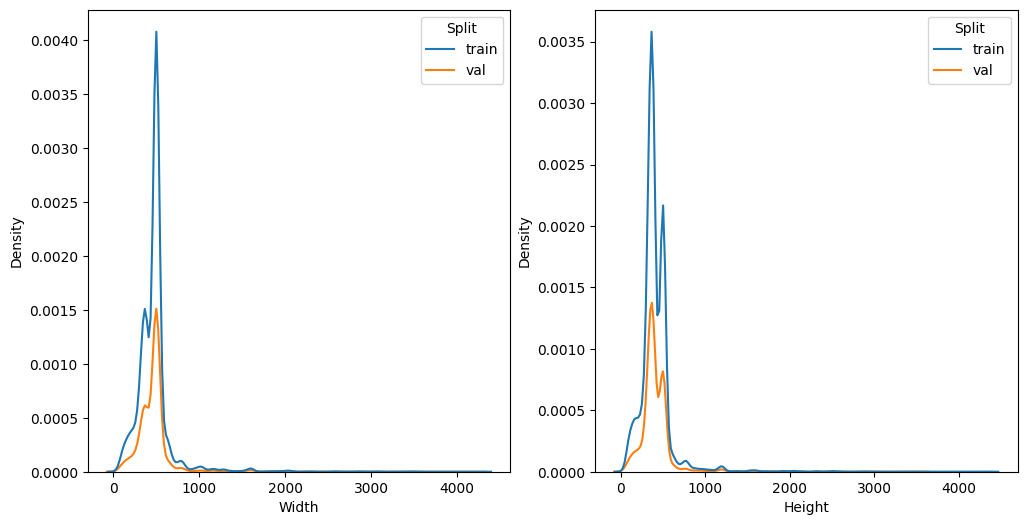

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.kdeplot(df, x="Width", hue="Split", ax=axes[0])
sns.kdeplot(df, x="Height", hue="Split", ax=axes[1])

In [6]:
df.describe()

,Width,Height
count,13394.000000,13394.000000
mean,470.789234,407.565178
std,227.341272,200.318296
min,50.000000,27.000000
25%,375.000000,333.000000
50%,500.000000,375.000000
75%,500.000000,500.000000
max,4288.000000,4368.000000


This confirms the number of images in the dataset that have dimensions less than 1000 pixels, both in height and width.

In [7]:
print(df[df['Height'] < 1000].value_counts('Split'))
print('='*50)
df[df['Width'] < 1000].value_counts('Split')


Split
train    9308
val      3859
Name: count, dtype: int64


Split
train    9235
val      3836
Name: count, dtype: int64

Category wise dataset stats

In [8]:
def count_images_per_category(image_dir):
    """
    Count the number of images per category in the given directory.

    Args:
    image_dir (str): The directory containing the images.

    Returns:
    dict: A nested dictionary containing counts of images per category for each split.
          The keys of the outer dictionary represent the splits ('train', 'val').
          The keys of the inner dictionaries represent the categories, and the values
          represent the counts of images in each category.
    """
    image_counts = {}

    for split in ['train', 'val']:
        split_dir = os.path.join(image_dir, split)
        categories = [category for category in os.listdir(split_dir) if not category.startswith('.')]

        image_counts[split] = {}
        for category in tqdm(categories, desc=f'Processing {split}'):
            category_dir = os.path.join(split_dir, category)
            images = [image for image in os.listdir(category_dir) if not image.startswith('.')]
            image_counts[split][category] = len(images)

    return image_counts

category_counts = count_images_per_category(DATASET_PATH)

# Print the counts
for split, categories in category_counts.items():
    print(f"\n{split.capitalize()} split:")
    for category, count in categories.items():
        print(f"- Category {category}: {count} images")


Processing train:   0%|          | 0/10 [00:00<?, ?it/s]

Processing val:   0%|          | 0/10 [00:00<?, ?it/s]


Train split:
- Category n01440764: 963 images
- Category n02102040: 955 images
- Category n02979186: 993 images
- Category n03000684: 858 images
- Category n03028079: 941 images
- Category n03394916: 956 images
- Category n03417042: 961 images
- Category n03425413: 931 images
- Category n03445777: 951 images
- Category n03888257: 960 images

Val split:
- Category n01440764: 387 images
- Category n02102040: 395 images
- Category n02979186: 357 images
- Category n03000684: 386 images
- Category n03028079: 409 images
- Category n03394916: 394 images
- Category n03417042: 389 images
- Category n03425413: 419 images
- Category n03445777: 399 images
- Category n03888257: 390 images


Train and validation set split details

In [9]:
counts = df.value_counts('Split')
percs = df.value_counts('Split', normalize=True).mul(100).round(1).astype(str) + '%'
pd.concat([counts,percs], axis=1, keys=['count', 'percentage'])

,count,percentage
Split,,
train,9469,70.7%
val,3925,29.3%


Below code displays smallest and largest images in our dataset by height and width

Smallest image in train set by height:


,Width,Height,Split,Class,Image_Path
3365,80,27,train,n03000684,Image_set\train\n03000684\n03000684_2293.JPEG


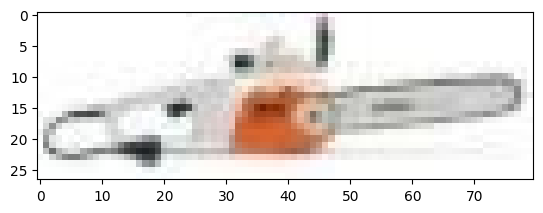

Smallest image in validation set by height:


,Width,Height,Split,Class,Image_Path
10779,82,32,val,n03000684,Image_set\val\n03000684\n03000684_19591.JPEG


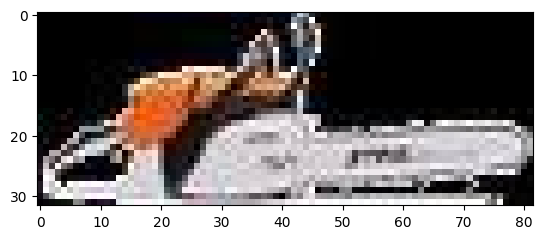

Largest image in train set by height:


,Width,Height,Split,Class,Image_Path
7350,2912,4368,train,n03425413,Image_set\train\n03425413\n03425413_28685.JPEG


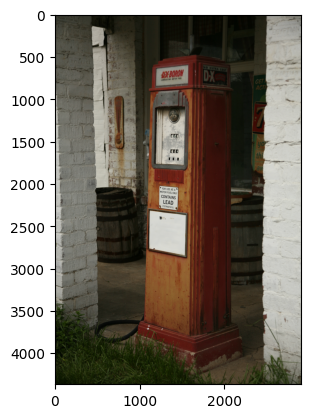

Largest image in validation set by height:


,Width,Height,Split,Class,Image_Path
12550,1950,3521,val,n03425413,Image_set\val\n03425413\n03425413_5301.JPEG


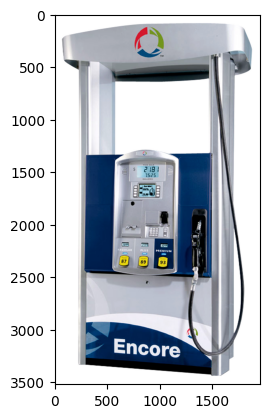

Smallest image in train set by width:


,Width,Height,Split,Class,Image_Path
2949,50,50,train,n03000684,Image_set\train\n03000684\n03000684_1014.JPEG


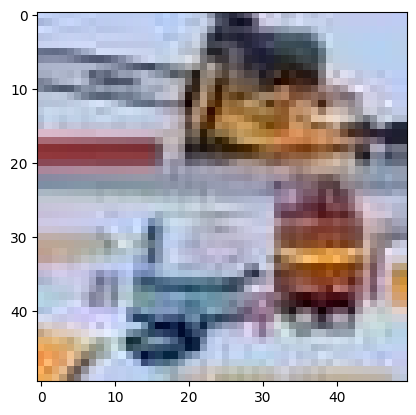

Smallest image in validation set by width:


,Width,Height,Split,Class,Image_Path
10728,50,50,val,n03000684,Image_set\val\n03000684\n03000684_16481.JPEG


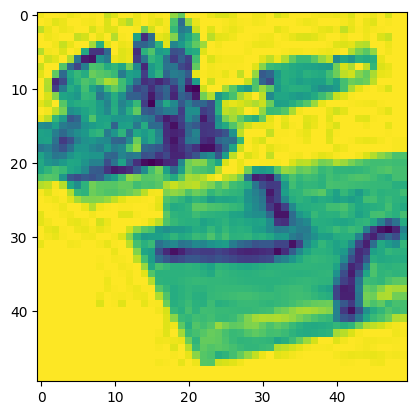

Largest image in train set by width:


,Width,Height,Split,Class,Image_Path
240,4288,2848,train,n01440764,Image_set\train\n01440764\n01440764_13368.JPEG


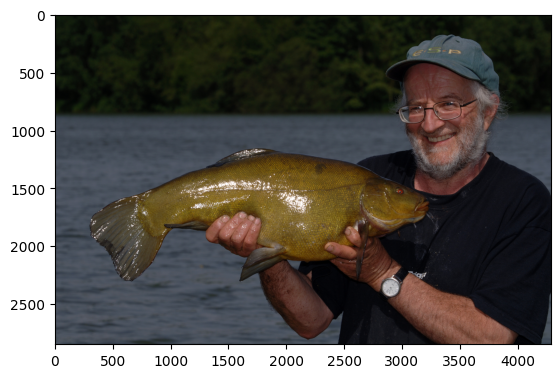

Largest image in validation set by width:


,Width,Height,Split,Class,Image_Path
10275,4214,1866,val,n02979186,Image_set\val\n02979186\n02979186_1061.JPEG


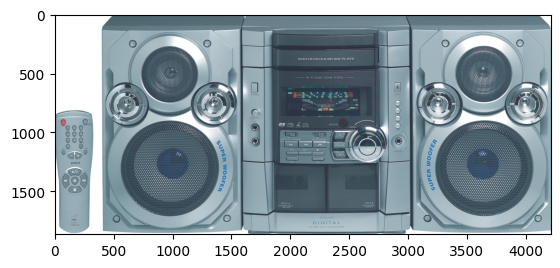

In [10]:
print("Smallest image in train set by height:")

data = df[df['Split'] == 'train'].nsmallest(1, 'Height')
image_path = data['Image_Path'].values[0] 
display(data)

img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()

print("Smallest image in validation set by height:")

data = df[df['Split'] == 'val'].nsmallest(1, 'Height')
image_path = data['Image_Path'].values[0] 
display(data)

img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()

print("Largest image in train set by height:")

data = df[df['Split'] == 'train'].nlargest(1, 'Height')
image_path = data['Image_Path'].values[0] 
display(data)

img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()

print("Largest image in validation set by height:")

data = df[df['Split'] == 'val'].nlargest(1, 'Height')
image_path = data['Image_Path'].values[0] 
display(data)

img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()

print("="*50)

print("Smallest image in train set by width:")

data = df[df['Split'] == 'train'].nsmallest(1, 'Width')
image_path = data['Image_Path'].values[0] 
display(data)

img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()

print("Smallest image in validation set by width:")

data = df[df['Split'] == 'val'].nsmallest(1, 'Width')
image_path = data['Image_Path'].values[0] 
display(data)

img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()

print("Largest image in train set by width:")

data = df[df['Split'] == 'train'].nlargest(1, 'Width')
image_path = data['Image_Path'].values[0] 
display(data)

img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()

print("Largest image in validation set by width:")

data = df[df['Split'] == 'val'].nlargest(1, 'Width')
image_path = data['Image_Path'].values[0] 
display(data)

img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()


## Data Loader

This code snippet loads images from the `image_set` folder and resizes them to 224x224 pixels. The decision to use this specific dimension is to match the input size required by most pre-trained models in TensorFlow.

The images are loaded in batches of 32. This choice is made for several reasons:

1. Memory Efficiency: Loading the images in batches helps manage memory more efficiently, especially when dealing with large datasets.

2. Regularization: Batch loading introduces a form of regularization known as "batch normalization."

3. Training Speed: Loading data in batches can accelerate the training process.

Apart from resizing the images to 224x224 dimensions, no other modifications are made to the images during the loading process.

In [11]:
# Define data directories
data_root = DATASET_PATH
train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'val')

# Define parameters for the dataset
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Create a dataset for each split (train and validation)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',  # Labels are the names of subdirectories
    label_mode='categorical',  # One-hot encoding of labels
    color_mode='rgb',  # Images are RGB
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,  # For reproducibility
    interpolation='bilinear',
    follow_links=False
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,  # It's generally a good practice not to shuffle the validation set
    seed=42,
    interpolation='bilinear',
    follow_links=False
)

output_file = 'classes.yaml'

# Write the list to a YAML file
with open(output_file, 'w') as f:
    yaml.dump(train_dataset.class_names, f)

# You can then prefetch your datasets for performance
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

Found 9469 files belonging to 10 classes.
Found 3925 files belonging to 10 classes.


Below mentioned pre-trained Tensorflow models are used to classify images. The reason behind selecting pre-trained models with `ImageNet` weights is advantageous for transfer learning, feature extraction, faster training, better generalization, and leveraging established architectures in deep learning tasks.

Following pre-trained models are used for experiments:

| S.No. | Model | Reference|
|:-----:|:-----:|:--------:|
| 1. | ResNet50 | ([Deep Residual Learning for Image Recognition (CVPR 2015)](https://arxiv.org/abs/1512.03385)) |
| 2. | ResNet101 | ([Deep Residual Learning for Image Recognition (CVPR 2015)](https://arxiv.org/abs/1512.03385)) |
| 3. | ResNet152 | ([Deep Residual Learning for Image Recognition (CVPR 2015)](https://arxiv.org/abs/1512.03385)) |
| 4. | VGG19 | ([Very Deep Convolutional Networks for Large-Scale Image Recognition (ICLR 2015)](https://arxiv.org/abs/1409.1556)) |
| 5. | VGG16 | ([Very Deep Convolutional Networks for Large-Scale Image Recognition (ICLR 2015)](https://arxiv.org/abs/1409.1556)) |
| 6. | EfficientNetB0 | ([EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks (ICML 2019)](https://arxiv.org/abs/1905.11946)) |
| 7. | EfficientNetV2B0 | ([EfficientNetV2: Smaller Models and Faster Training (ICML 2021)](https://arxiv.org/abs/2104.00298)) |
| 8. | EfficientNetV2L | ([EfficientNetV2: Smaller Models and Faster Training (ICML 2021)](https://arxiv.org/abs/2104.00298)) |
| 9. | DenseNet121 | ([Densely Connected Convolutional Networks (CVPR 2017)](https://arxiv.org/abs/1608.06993)) |
| 10. | DenseNet169 | ([Densely Connected Convolutional Networks (CVPR 2017)](https://arxiv.org/abs/1608.06993)) |
| 11. | DenseNet201 | ([Densely Connected Convolutional Networks (CVPR 2017)](https://arxiv.org/abs/1608.06993)) |

Two variations of input data are employed for experimentation purposes. One approach involves passing the complete data without any random data augmentation or preprocessing other than resizing and another approach is to apply data augmentation on images and using regularization method like `Dropout`. This approach facilitates not only the comparison of experiments among different models but also the assessment of the impact of data augmentation on the results.

In [12]:
models = [
    ("ResNet50", ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')),
    ("ResNet101", ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')),
    ("ResNet152", ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')),
    ("VGG19", VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')),
    ("VGG16", VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')),
    ("EfficientNetB0", EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')),
    ("EfficientNetV2B0", EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')),
    ("EfficientNetV2L", EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')),
    ("DenseNet121", DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')),
    ("DenseNet169", DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')),
    ("DenseNet201", DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg'))
]

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Experiment 1
This experiment is not using any data augmentation or regularization technique. Training and validation images are passed to these models without any preprocessing

Model ResNet50 Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

None
Training Model ResNet50
Epoch 1/10
  2/296 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step - accuracy: 0.1641 - loss: 2.9483   

I0000 00:00:1710439210.380324      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710439210.428574      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8347 - loss: 0.5395

W0000 00:00:1710439241.002820      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710439245.138498      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 67s 170ms/step - accuracy: 0.8350 - loss: 0.5385 - val_accuracy: 0.9564 - val_loss: 0.1393
Epoch 2/10


W0000 00:00:1710439260.641034      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.9698 - loss: 0.1038 - val_accuracy: 0.9697 - val_loss: 0.0983
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step - accuracy: 0.9819 - loss: 0.0626 - val_accuracy: 0.9702 - val_loss: 0.1029
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - accuracy: 0.9898 - loss: 0.0425 - val_accuracy: 0.9694 - val_loss: 0.1006
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.9952 - loss: 0.0239 - val_accuracy: 0.9720 - val_loss: 0.0943
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step - accuracy: 0.9969 - loss: 0.0168 - val_accuracy: 0.9697 - val_loss: 0.0979
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.9996 - loss: 0.0106 - val_accuracy: 0.9715 - val_loss: 0.0972
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.9750 - val_loss: 0.0905
Epoch 9/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.9999 - loss: 0.0059 - val

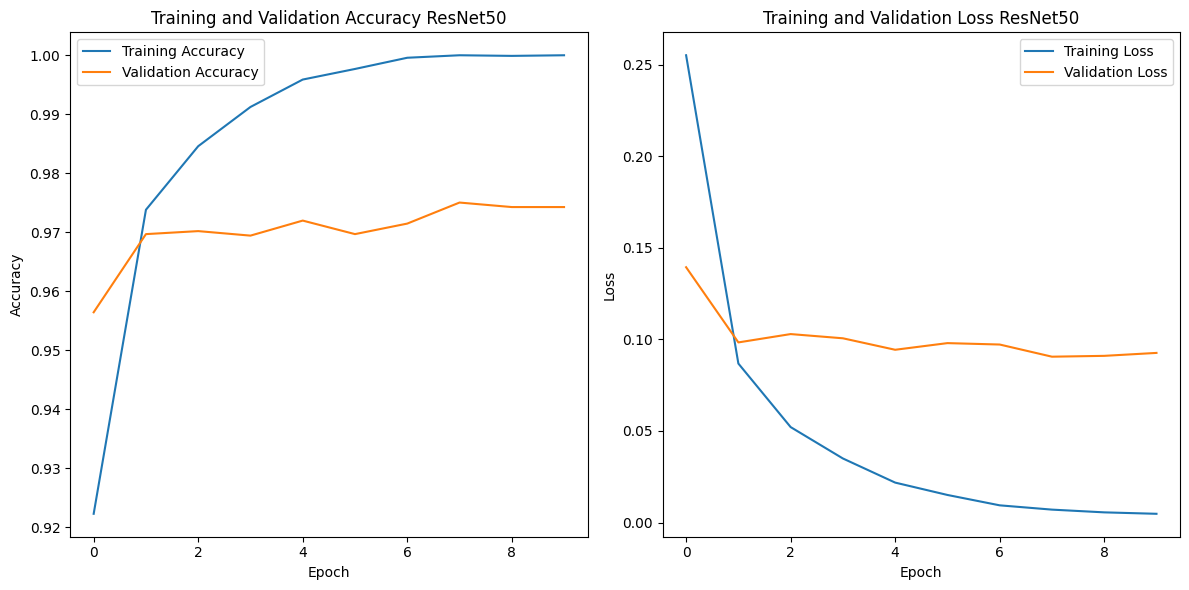

Model ResNet50 saved as ./models/ResNet50_1.keras
Model ResNet101 Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 2048)           │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,678,666 (162.81 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 42,658,176 (162.73 MB)

None
Training Model ResNet101
Epoch 1/10
  1/296 ━━━━━━━━━━━━━━━━━━━━ 1:27:04 18s/step - accuracy: 0.0625 - loss: 3.3437

W0000 00:00:1710439590.268038      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8227 - loss: 0.5972

W0000 00:00:1710439638.748011      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710439646.024320      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 94s 259ms/step - accuracy: 0.8231 - loss: 0.5961 - val_accuracy: 0.9638 - val_loss: 0.1147
Epoch 2/10


W0000 00:00:1710439666.658326      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 62s 208ms/step - accuracy: 0.9740 - loss: 0.0858 - val_accuracy: 0.9699 - val_loss: 0.0950
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 62s 206ms/step - accuracy: 0.9849 - loss: 0.0503 - val_accuracy: 0.9687 - val_loss: 0.0941
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 61s 206ms/step - accuracy: 0.9931 - loss: 0.0286 - val_accuracy: 0.9697 - val_loss: 0.0928
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 62s 206ms/step - accuracy: 0.9973 - loss: 0.0153 - val_accuracy: 0.9710 - val_loss: 0.0887
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 62s 206ms/step - accuracy: 0.9987 - loss: 0.0114 - val_accuracy: 0.9715 - val_loss: 0.0881
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 62s 206ms/step - accuracy: 0.9999 - loss: 0.0078 - val_accuracy: 0.9710 - val_loss: 0.0887
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 62s 206ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.9715 - val_loss: 0.0906
Epoch 9/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 62s 206ms/step - accuracy: 1.0000 - loss: 0.0045 - val

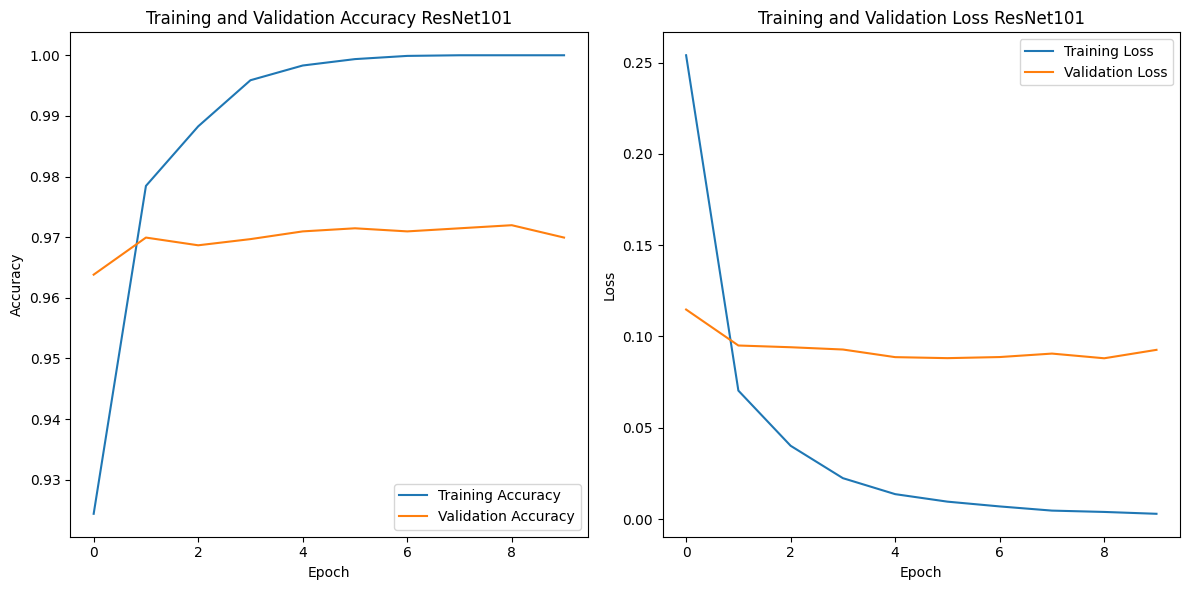

Model ResNet101 saved as ./models/ResNet101_1.keras
Model ResNet152 Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ (None, 2048)           │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,391,434 (222.75 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 58,370,944 (222.67 MB)

None
Training Model ResNet152
Epoch 1/10
  1/296 ━━━━━━━━━━━━━━━━━━━━ 2:06:36 26s/step - accuracy: 0.0938 - loss: 3.1020

W0000 00:00:1710440249.063258      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8261 - loss: 0.5852

W0000 00:00:1710440318.996420      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710440329.569796      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 136s 375ms/step - accuracy: 0.8265 - loss: 0.5841 - val_accuracy: 0.9608 - val_loss: 0.1233
Epoch 2/10


W0000 00:00:1710440359.717262      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 90s 302ms/step - accuracy: 0.9713 - loss: 0.0873 - val_accuracy: 0.9684 - val_loss: 0.0914
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 90s 301ms/step - accuracy: 0.9862 - loss: 0.0461 - val_accuracy: 0.9707 - val_loss: 0.0870
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 90s 301ms/step - accuracy: 0.9945 - loss: 0.0266 - val_accuracy: 0.9720 - val_loss: 0.0905
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 89s 300ms/step - accuracy: 0.9987 - loss: 0.0158 - val_accuracy: 0.9725 - val_loss: 0.0864
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 89s 301ms/step - accuracy: 0.9995 - loss: 0.0102 - val_accuracy: 0.9727 - val_loss: 0.0913
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 142s 302ms/step - accuracy: 0.9993 - loss: 0.0074 - val_accuracy: 0.9740 - val_loss: 0.0892
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 89s 301ms/step - accuracy: 0.9999 - loss: 0.0052 - val_accuracy: 0.9758 - val_loss: 0.0825
Epoch 9/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 89s 301ms/step - accuracy: 1.0000 - loss: 0.0035 - va

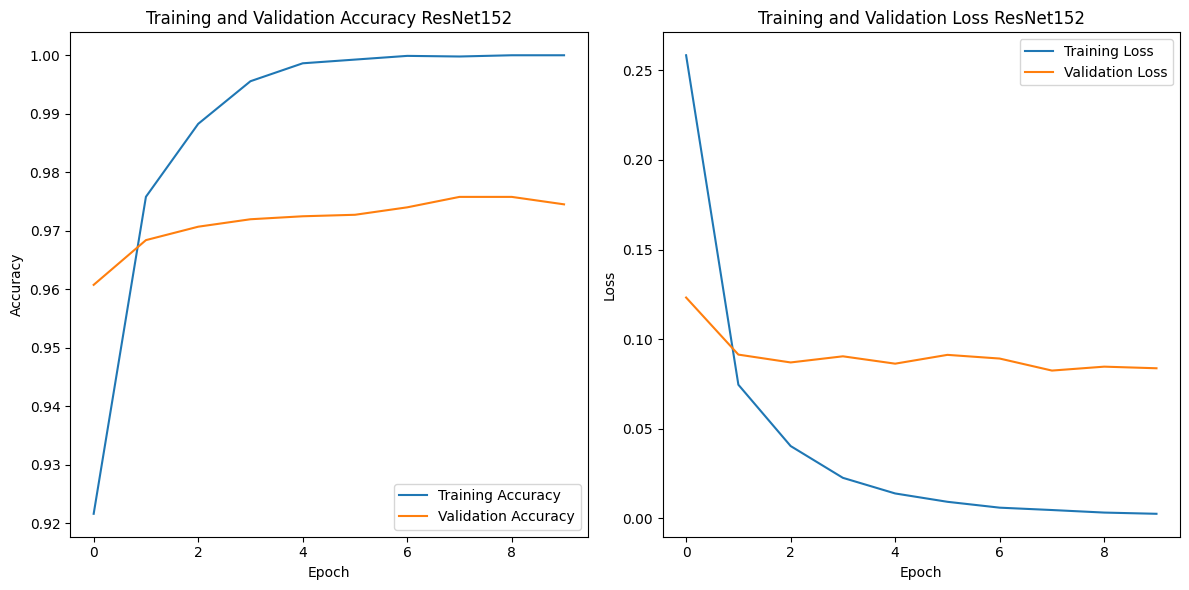

Model ResNet152 saved as ./models/ResNet152_1.keras
Model VGG19 Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 512)            │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,029,514 (76.41 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

None
Training Model VGG19
Epoch 1/10
  1/296 ━━━━━━━━━━━━━━━━━━━━ 2:42:57 33s/step - accuracy: 0.0312 - loss: 12.1548

W0000 00:00:1710441307.289958      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.5945 - loss: 3.0633

W0000 00:00:1710441382.048666      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710441383.365537      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 150s 395ms/step - accuracy: 0.5951 - loss: 3.0578 - val_accuracy: 0.8932 - val_loss: 0.5033
Epoch 2/10


W0000 00:00:1710441423.874652      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 66s 220ms/step - accuracy: 0.9087 - loss: 0.4349 - val_accuracy: 0.9182 - val_loss: 0.3612
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 66s 221ms/step - accuracy: 0.9358 - loss: 0.2564 - val_accuracy: 0.9304 - val_loss: 0.3028
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 66s 220ms/step - accuracy: 0.9559 - loss: 0.1685 - val_accuracy: 0.9345 - val_loss: 0.2892
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 66s 220ms/step - accuracy: 0.9646 - loss: 0.1233 - val_accuracy: 0.9394 - val_loss: 0.2676
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 66s 220ms/step - accuracy: 0.9771 - loss: 0.0843 - val_accuracy: 0.9355 - val_loss: 0.2786
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 66s 221ms/step - accuracy: 0.9835 - loss: 0.0602 - val_accuracy: 0.9396 - val_loss: 0.2817
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 66s 221ms/step - accuracy: 0.9856 - loss: 0.0509 - val_accuracy: 0.9419 - val_loss: 0.2605
Epoch 9/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 66s 220ms/step - accuracy: 0.9914 - loss: 0.0349 - val

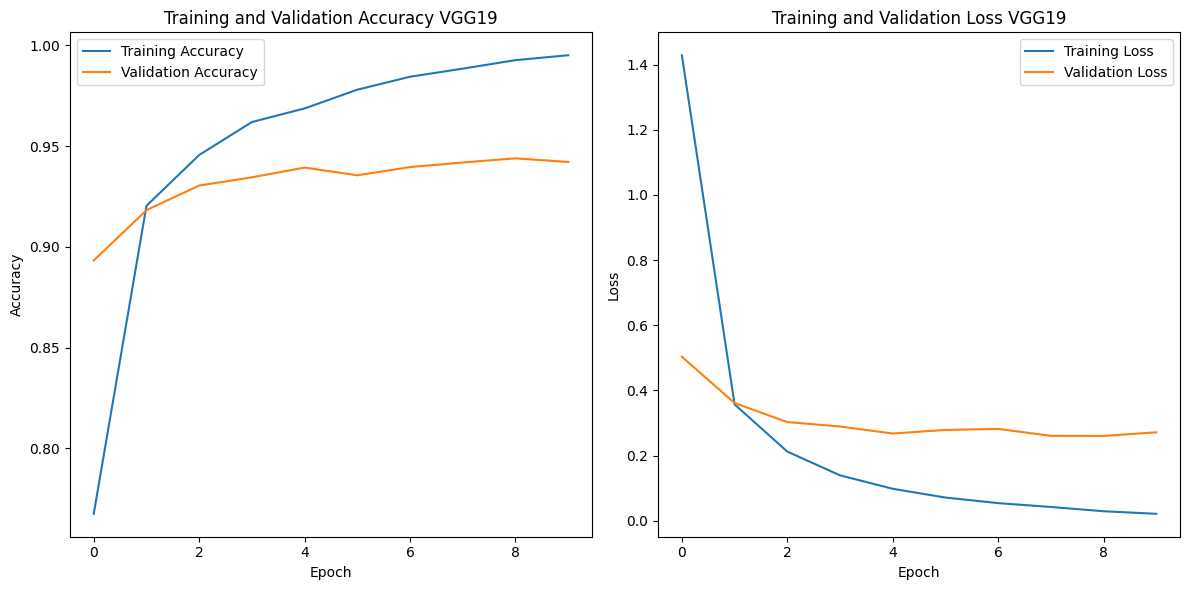

Model VGG19 saved as ./models/VGG19_1.keras
Model VGG16 Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Training Model VGG16
Epoch 1/10
  1/296 ━━━━━━━━━━━━━━━━━━━━ 12:12 2s/step - accuracy: 0.1562 - loss: 13.4505

W0000 00:00:1710442019.238793      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6313 - loss: 3.0686

W0000 00:00:1710442057.659191      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710442058.809564      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 58s 188ms/step - accuracy: 0.6318 - loss: 3.0630 - val_accuracy: 0.8818 - val_loss: 0.6168
Epoch 2/10


W0000 00:00:1710442074.620187      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 53s 179ms/step - accuracy: 0.9097 - loss: 0.4324 - val_accuracy: 0.9129 - val_loss: 0.4220
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 53s 178ms/step - accuracy: 0.9413 - loss: 0.2549 - val_accuracy: 0.9197 - val_loss: 0.3686
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 53s 178ms/step - accuracy: 0.9539 - loss: 0.1704 - val_accuracy: 0.9233 - val_loss: 0.3446
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 53s 178ms/step - accuracy: 0.9675 - loss: 0.1191 - val_accuracy: 0.9228 - val_loss: 0.3357
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 53s 179ms/step - accuracy: 0.9737 - loss: 0.0794 - val_accuracy: 0.9256 - val_loss: 0.3359
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 53s 179ms/step - accuracy: 0.9803 - loss: 0.0639 - val_accuracy: 0.9304 - val_loss: 0.3179
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 53s 179ms/step - accuracy: 0.9826 - loss: 0.0500 - val_accuracy: 0.9282 - val_loss: 0.3140
Epoch 9/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 53s 179ms/step - accuracy: 0.9903 - loss: 0.0329 - val

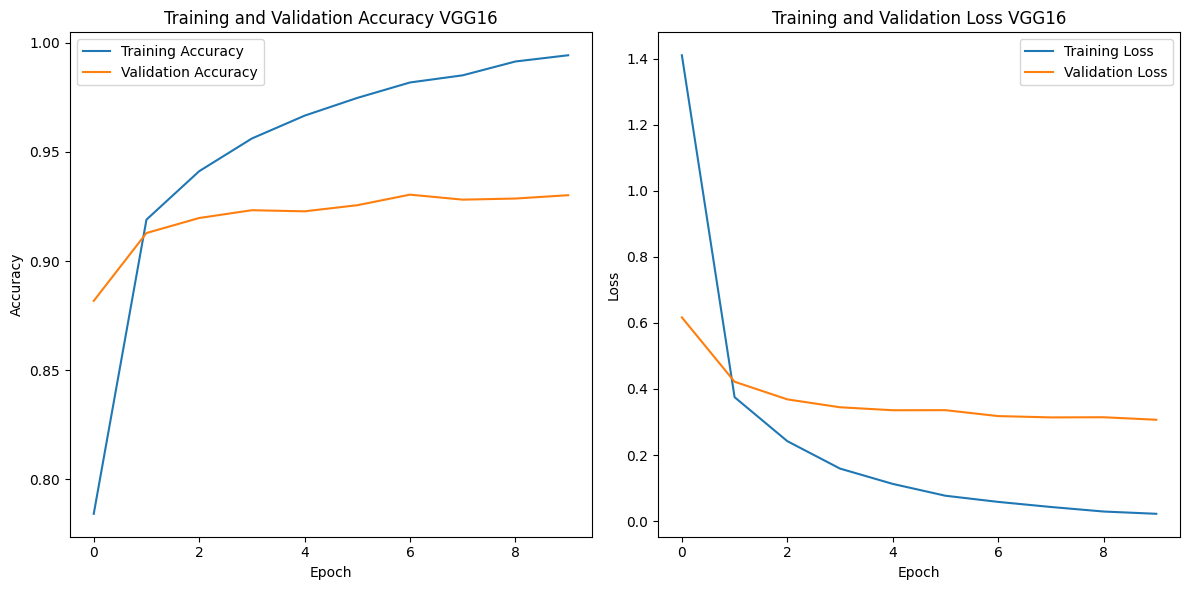

Model VGG16 saved as ./models/VGG16_1.keras
Model EfficientNetB0 Summary:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

None
Training Model EfficientNetB0
Epoch 1/10
  4/296 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.1289 - loss: 2.3353

W0000 00:00:1710442589.104239      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8758 - loss: 0.6013

W0000 00:00:1710442626.345444      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710442632.447873      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 91s 195ms/step - accuracy: 0.8761 - loss: 0.6001 - val_accuracy: 0.9890 - val_loss: 0.0504
Epoch 2/10


W0000 00:00:1710442646.760239      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9869 - loss: 0.0538 - val_accuracy: 0.9911 - val_loss: 0.0353
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.9914 - loss: 0.0331 - val_accuracy: 0.9908 - val_loss: 0.0309
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.9940 - loss: 0.0230 - val_accuracy: 0.9924 - val_loss: 0.0279
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.9970 - loss: 0.0154 - val_accuracy: 0.9918 - val_loss: 0.0269
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.9983 - loss: 0.0133 - val_accuracy: 0.9924 - val_loss: 0.0258
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - accuracy: 0.9992 - loss: 0.0087 - val_accuracy: 0.9924 - val_loss: 0.0256
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.9993 - loss: 0.0069 - val_accuracy: 0.9929 - val_loss: 0.0251
Epoch 9/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.9989 - loss: 0.0071 - val_accurac

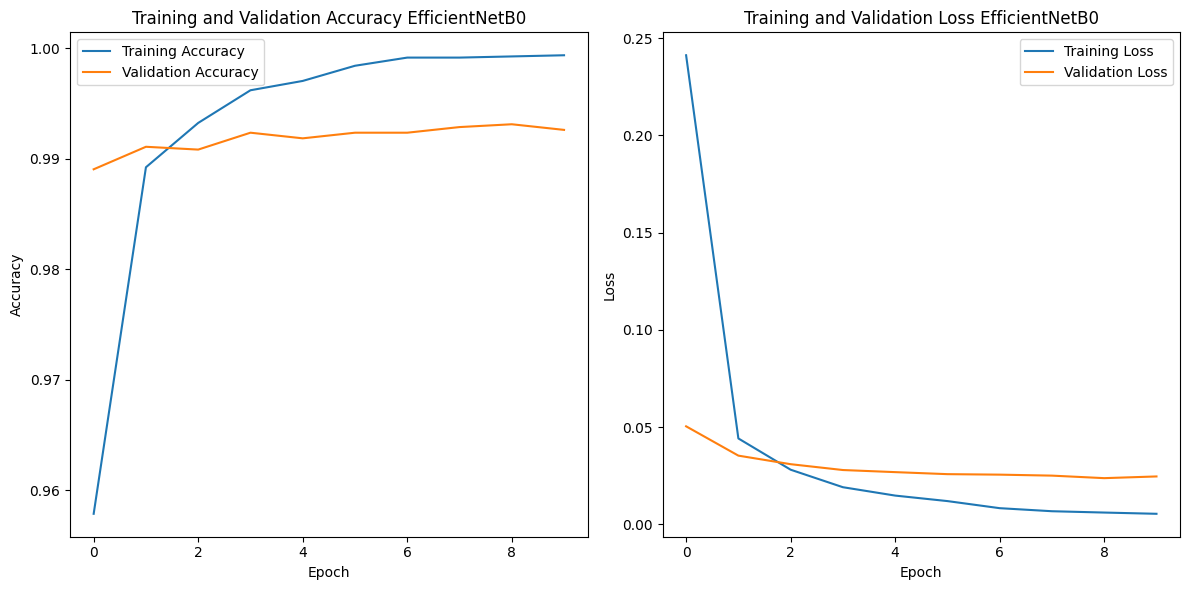

Model EfficientNetB0 saved as ./models/EfficientNetB0_1.keras
Model EfficientNetV2B0 Summary:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

None
Training Model EfficientNetV2B0
Epoch 1/10
  3/296 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.1181 - loss: 2.2911

W0000 00:00:1710442906.803367      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9078 - loss: 0.5368

W0000 00:00:1710442950.649735      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710442958.570715      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 105s 218ms/step - accuracy: 0.9080 - loss: 0.5356 - val_accuracy: 0.9949 - val_loss: 0.0302
Epoch 2/10


W0000 00:00:1710442971.021255      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.9956 - loss: 0.0270 - val_accuracy: 0.9959 - val_loss: 0.0201
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.9972 - loss: 0.0147 - val_accuracy: 0.9959 - val_loss: 0.0170
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.9981 - loss: 0.0100 - val_accuracy: 0.9967 - val_loss: 0.0158
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.9994 - loss: 0.0082 - val_accuracy: 0.9964 - val_loss: 0.0144
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.9993 - loss: 0.0065 - val_accuracy: 0.9967 - val_loss: 0.0135
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.9998 - loss: 0.0040 - val_accuracy: 0.9969 - val_loss: 0.0136
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.9998 - loss: 0.0044 - val_accuracy: 0.9975 - val_loss: 0.0136
Epoch 9/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - accuracy: 0.9999 - loss: 0.0025 - val_accurac

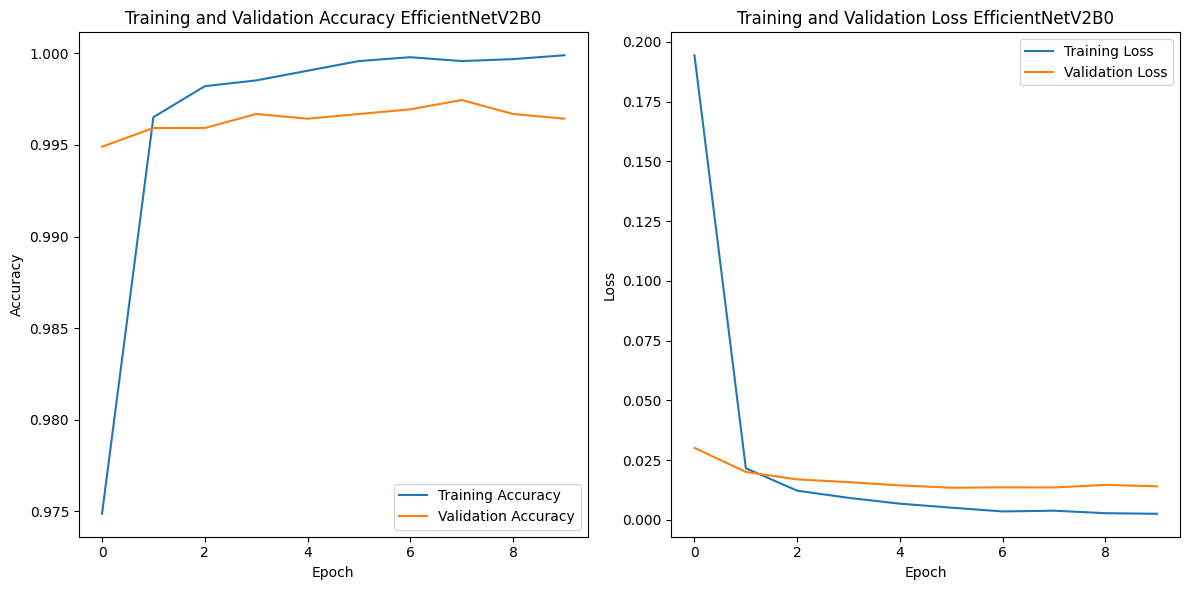

Model EfficientNetV2B0 saved as ./models/EfficientNetV2B0_1.keras
Model EfficientNetV2L Summary:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-l (Functional)   │ (None, 1280)           │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,759,658 (449.22 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 117,746,848 (449.17 MB)

None
Training Model EfficientNetV2L
Epoch 1/10
  1/296 ━━━━━━━━━━━━━━━━━━━━ 15:10:57 185s/step - accuracy: 0.0312 - loss: 2.3933

W0000 00:00:1710443353.735633      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.9290 - loss: 0.5368

W0000 00:00:1710443586.879167      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710443606.882186      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 493s 1s/step - accuracy: 0.9292 - loss: 0.5356 - val_accuracy: 0.9972 - val_loss: 0.0253
Epoch 2/10


W0000 00:00:1710443661.985463      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 122s 410ms/step - accuracy: 0.9945 - loss: 0.0307 - val_accuracy: 0.9972 - val_loss: 0.0161
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 122s 411ms/step - accuracy: 0.9967 - loss: 0.0183 - val_accuracy: 0.9972 - val_loss: 0.0135
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 122s 411ms/step - accuracy: 0.9983 - loss: 0.0124 - val_accuracy: 0.9967 - val_loss: 0.0125
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 122s 410ms/step - accuracy: 0.9984 - loss: 0.0101 - val_accuracy: 0.9967 - val_loss: 0.0119
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 122s 410ms/step - accuracy: 0.9997 - loss: 0.0065 - val_accuracy: 0.9967 - val_loss: 0.0114
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 122s 411ms/step - accuracy: 0.9992 - loss: 0.0059 - val_accuracy: 0.9969 - val_loss: 0.0110
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 122s 411ms/step - accuracy: 0.9999 - loss: 0.0037 - val_accuracy: 0.9967 - val_loss: 0.0112
Epoch 9/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 122s 410ms/step - accuracy: 0.9989 - loss: 0.00

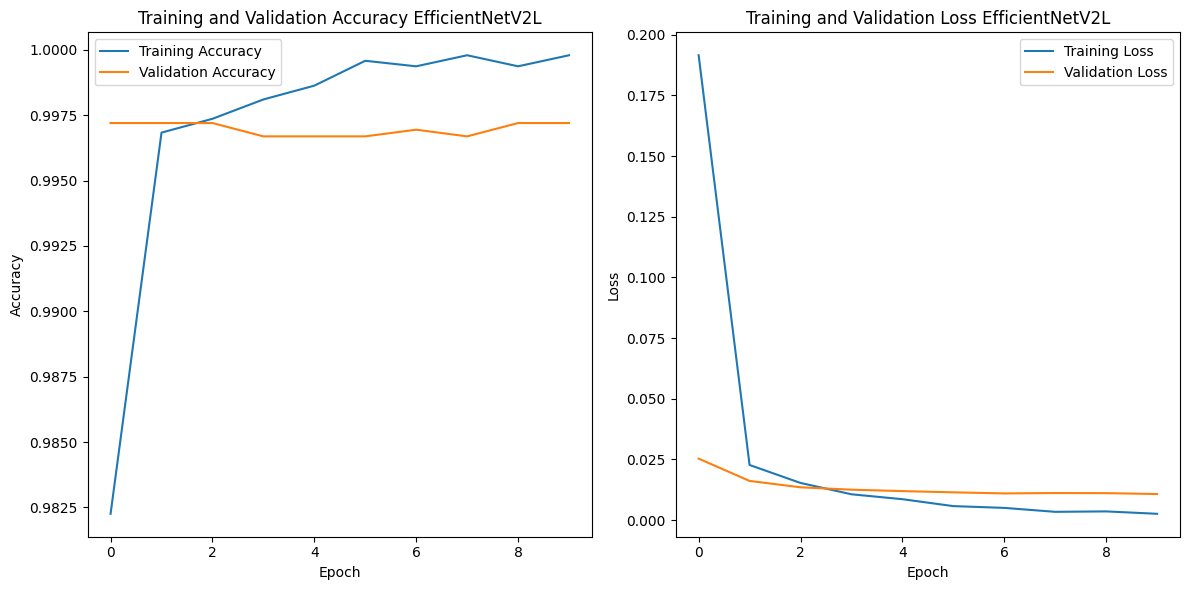

Model EfficientNetV2L saved as ./models/EfficientNetV2L_1.keras
Model DenseNet121 Summary:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,047,754 (26.89 MB)

 Trainable params: 10,250 (40.04 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

None
Training Model DenseNet121
Epoch 1/10
  2/296 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - accuracy: 0.0547 - loss: 10.7591  

W0000 00:00:1710444801.067348      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3225 - loss: 3.5998

W0000 00:00:1710444844.302057      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710444854.437663      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 116s 268ms/step - accuracy: 0.3230 - loss: 3.5955 - val_accuracy: 0.5758 - val_loss: 1.4767
Epoch 2/10


W0000 00:00:1710444880.200236      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - accuracy: 0.6181 - loss: 1.3440 - val_accuracy: 0.6561 - val_loss: 1.1785
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - accuracy: 0.6813 - loss: 1.0824 - val_accuracy: 0.6757 - val_loss: 1.1006
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - accuracy: 0.7077 - loss: 0.9837 - val_accuracy: 0.6966 - val_loss: 1.0096
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - accuracy: 0.7273 - loss: 0.8963 - val_accuracy: 0.7213 - val_loss: 0.9699
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.7381 - loss: 0.8238 - val_accuracy: 0.7350 - val_loss: 0.8855
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - accuracy: 0.7523 - loss: 0.7715 - val_accuracy: 0.7208 - val_loss: 0.9755
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - accuracy: 0.7625 - loss: 0.7731 - val_accuracy: 0.7327 - val_loss: 0.9135
Epoch 9/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - accuracy: 0.7649 - loss: 0.7466 - val

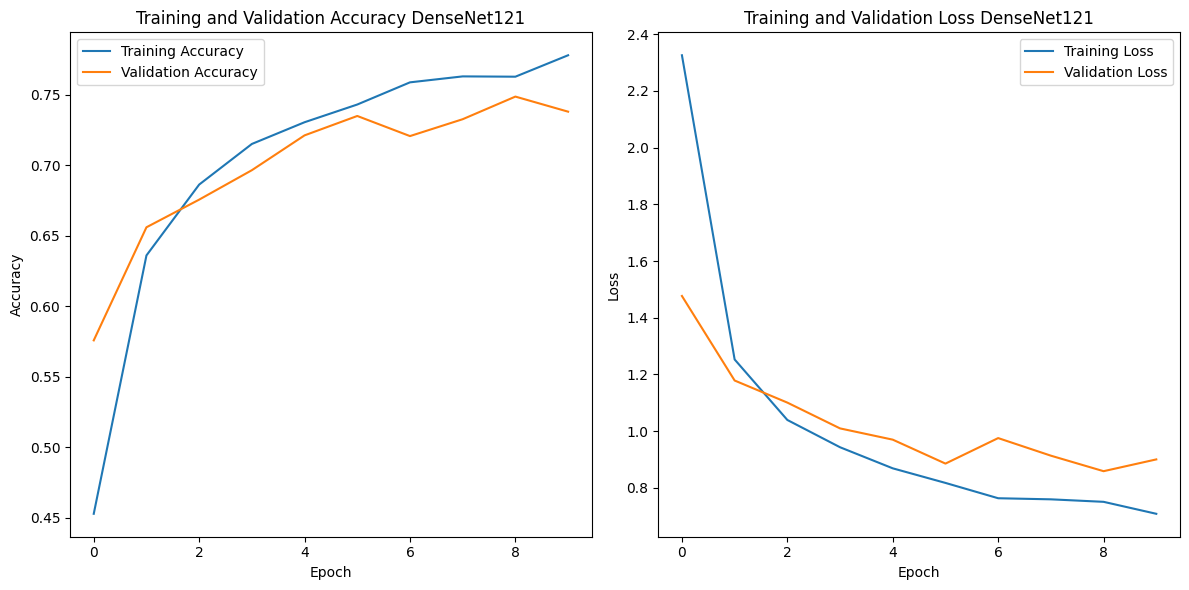

Model DenseNet121 saved as ./models/DenseNet121_1.keras
Model DenseNet169 Summary:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)        │ (None, 1664)           │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │        16,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,659,530 (48.29 MB)

 Trainable params: 16,650 (65.04 KB)

 Non-trainable params: 12,642,880 (48.23 MB)

None
Training Model DenseNet169
Epoch 1/10
  2/296 ━━━━━━━━━━━━━━━━━━━━ 33s 114ms/step - accuracy: 0.0391 - loss: 12.6566  

W0000 00:00:1710445216.251320      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3187 - loss: 3.9085

W0000 00:00:1710445259.733580      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710445273.734882      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 115s 276ms/step - accuracy: 0.3192 - loss: 3.9038 - val_accuracy: 0.5562 - val_loss: 1.6478
Epoch 2/10


W0000 00:00:1710445297.813045      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - accuracy: 0.5936 - loss: 1.4614 - val_accuracy: 0.6239 - val_loss: 1.3289
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 39s 131ms/step - accuracy: 0.6484 - loss: 1.2263 - val_accuracy: 0.6650 - val_loss: 1.1831
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.6817 - loss: 1.1186 - val_accuracy: 0.6757 - val_loss: 1.2330
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - accuracy: 0.7067 - loss: 1.0032 - val_accuracy: 0.6660 - val_loss: 1.3489
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - accuracy: 0.7181 - loss: 0.9526 - val_accuracy: 0.7009 - val_loss: 1.0994
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.7163 - loss: 0.9480 - val_accuracy: 0.7032 - val_loss: 1.0824
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - accuracy: 0.7456 - loss: 0.8660 - val_accuracy: 0.6887 - val_loss: 1.2409
Epoch 9/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.7386 - loss: 0.8699 - val

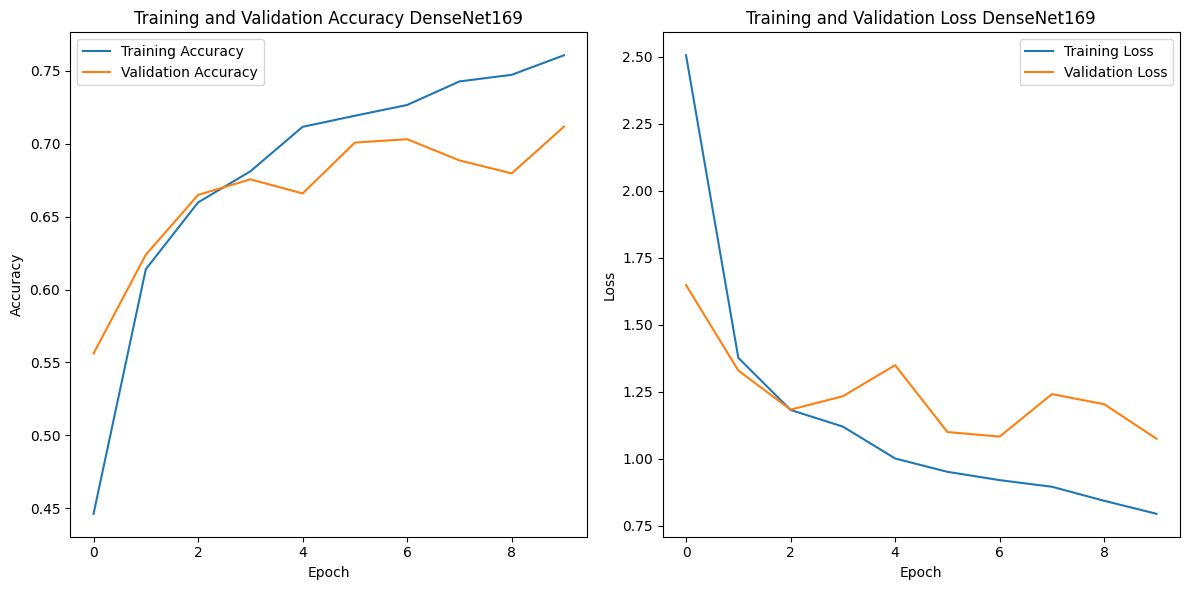

Model DenseNet169 saved as ./models/DenseNet169_1.keras
Model DenseNet201 Summary:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 1920)           │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │        19,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,341,194 (69.97 MB)

 Trainable params: 19,210 (75.04 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

None
Training Model DenseNet201
Epoch 1/10
  1/296 ━━━━━━━━━━━━━━━━━━━━ 3:31:08 43s/step - accuracy: 0.0938 - loss: 9.2195

W0000 00:00:1710445701.919362      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.3878 - loss: 2.7261

W0000 00:00:1710445756.848823      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710445774.142980      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 145s 346ms/step - accuracy: 0.3882 - loss: 2.7232 - val_accuracy: 0.5875 - val_loss: 1.4240
Epoch 2/10


W0000 00:00:1710445804.179058      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


296/296 ━━━━━━━━━━━━━━━━━━━━ 51s 172ms/step - accuracy: 0.6484 - loss: 1.1754 - val_accuracy: 0.6787 - val_loss: 1.0987
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 50s 169ms/step - accuracy: 0.7082 - loss: 0.9610 - val_accuracy: 0.6734 - val_loss: 1.1159
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 51s 171ms/step - accuracy: 0.7227 - loss: 0.8969 - val_accuracy: 0.6746 - val_loss: 1.2090
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 51s 170ms/step - accuracy: 0.7510 - loss: 0.8154 - val_accuracy: 0.7108 - val_loss: 1.0135
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 51s 171ms/step - accuracy: 0.7614 - loss: 0.7630 - val_accuracy: 0.7118 - val_loss: 1.0198
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 51s 171ms/step - accuracy: 0.7707 - loss: 0.7518 - val_accuracy: 0.7124 - val_loss: 1.0104
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 51s 170ms/step - accuracy: 0.7649 - loss: 0.7507 - val_accuracy: 0.7251 - val_loss: 0.9935
Epoch 9/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 51s 170ms/step - accuracy: 0.7900 - loss: 0.6802 - val

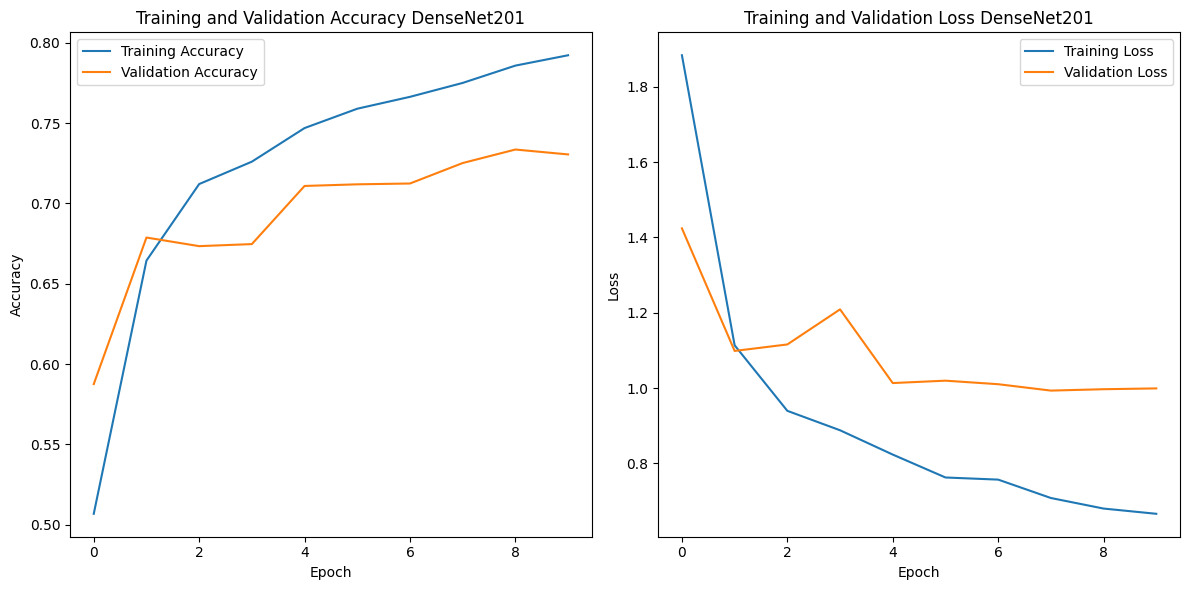

Model DenseNet201 saved as ./models/DenseNet201_1.keras


ResNet50                                  ResNet101                         \
   accuracy      loss val_accuracy  val_loss  accuracy      loss val_accuracy   
0  0.922273  0.255046     0.956433  0.139345  0.924385  0.254006     0.963822   
1  0.973809  0.086775     0.969682  0.098311  0.978456  0.070346     0.969936   
2  0.984581  0.052093     0.970191  0.102859  0.988278  0.040129     0.968662   
3  0.991235  0.034957     0.969427  0.100558  0.995881  0.022388     0.969682   
4  0.995881  0.021790     0.971975  0.094292  0.998310  0.013637     0.970955   
5  0.997677  0.015044     0.969682  0.097924  0.999366  0.009528     0.971465   
6  0.999578  0.009381     0.971465  0.097155  0.999894  0.006910     0.970955   
7  1.000000  0.007040     0.975032  0.090515  1.000000  0.004620     0.971465   
8  0.999894  0.005546     0.974268  0.090972  1.000000  0.003891     0.971975   
9  1.000000  0.004762     0.974268  0.092579  1.000000  0.002875     0.969936   

            ResNet152            ...  DenseNet121           DenseNet169  \
   val_loss  accuracy      loss  ... val_accuracy  val_loss    accuracy   
0  0.114746  0.921639  0.258429  ...     0.575796  1.476724    0.446193   
1  0.095044  0.975816  0.074617  ...     0.656051  1.178522    0.614004   
2  0.094096  0.988278  0.040409  ...     0.675669  1.100620    0.659837   
3  0.092849  0.995564  0.022663  ...     0.696561  1.009612    0.681170   
4  0.088672  0.998627  0.013952  ...     0.721274  0.969926    0.711691   
5  0.088120  0.999261  0.009298  ...     0.735032  0.885491    0.719295   
6  0.088722  0.999894  0.006020  ...     0.720764  0.975475    0.726687   
7  0.090618  0.999789  0.004706  ...     0.732739  0.913457    0.742845   
8  0.088050  1.000000  0.003284  ...     0.748790  0.858727    0.747386   
9  0.092666  1.000000  0.002604  ...     0.738089  0.900273    0.760798   

                                   DenseNet201                         \
       loss val_accuracy  val_loss    accuracy      loss val_accuracy   
0  2.505261     0.556178  1.647751    0.506812  1.883402     0.587516   
1  1.376381     0.623949  1.328909    0.664379  1.113661     0.678726   
2  1.181725     0.664968  1.183071    0.712008  0.939741     0.673376   
3  1.119701     0.675669  1.232955    0.725948  0.888168     0.674650   
4  1.000714     0.665987  1.348861    0.746858  0.823670     0.710828   
5  0.950939     0.700892  1.099359    0.758897  0.762871     0.711847   
6  0.919898     0.703185  1.082426    0.766290  0.757223     0.712357   
7  0.895167     0.688662  1.240894    0.774950  0.708420     0.725096   
8  0.842797     0.679745  1.203223    0.785722  0.680397     0.733503   
9  0.794311     0.711847  1.074424    0.792164  0.666508     0.730446   

             
   val_loss  
0  1.424014  
1  1.098715  
2  1.115943  
3  1.209023  
4  1.013490  
5  1.019791  
6  1.010435  
7  0.993468  
8  0.997122  
9  0.999282  

[10 rows x 44 columns]

DataFrame saved as ./metrics/model_1_history.parquet


In [13]:
# Initialize an empty DataFrame
df = pd.DataFrame()

# Iterate over each model in the list of models
for model_name, base_model in models:
    # Freeze the base model to prevent its weights from being updated during training
    base_model.trainable = False

    model = Sequential([
    base_model,  # Add the base model
    Dense(10, activation='softmax')  # Add Dense output layer
])

    model.build(input_shape=(None, 224, 224, 3))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    # Print model summary
    print(f"Model {model_name} Summary:")
    print(model.summary())
    
    # Save the model architecture as an image
    file_name = f"./architecture/{model_name}_1.png"
    plot_model(model, to_file=file_name, show_shapes=True,show_layer_names=True, show_layer_activations=True, show_trainable=True)

    # Train the model
    print(f"Training Model {model_name}")
    
    # Uncomment the following line to train the model in a GPU environment
    # with tf.device('/gpu:0'):
    #    history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)
    
    history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

    # Print final accuracy
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history.get('val_accuracy', None)
    if val_acc:
        val_acc = val_acc[-1]
        print(f"Model {model_name}: Training Accuracy - {train_acc:.4f}, Validation Accuracy - {val_acc:.4f}")
    else:
        print(f"Model {model_name}: Training Accuracy - {train_acc:.4f}")
        
    # Display model training progress
    print(f"{'='*50} {model_name} {'='*50}")
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss {model_name}')
    plt.legend()

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy {model_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()
        
    # Convert history.history to DataFrame
    model_history = pd.DataFrame(history.history)
    
    # Add a multi-level column with model name
    model_history.columns = pd.MultiIndex.from_product([[model_name], model_history.columns])
    
    # Concatenate model history with existing DataFrame
    df = pd.concat([df, model_history], axis=1)
    
    # Save the trained model
    model_filename = f"./models/{model_name}_1.keras"
    model.save(model_filename)
    print(f"Model {model_name} saved as {model_filename}")

# Display the aggregated DataFrame
display(df)

# Save the DataFrame as a Parquet file
parquet_filename = "./metrics/model_1_history.parquet"
df.to_parquet(parquet_filename)
print(f"DataFrame saved as {parquet_filename}")


# Experiment 2
This experiment uses input data augmentation and 50% `Dropout` as reqularization technique.

Model ResNet50 Summary:


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

None
Training Model ResNet50
Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 72s 204ms/step - accuracy: 0.5966 - loss: 1.3063 - val_accuracy: 0.9126 - val_loss: 0.2866
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 54s 182ms/step - accuracy: 0.8295 - loss: 0.5389 - val_accuracy: 0.9289 - val_loss: 0.2220
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 54s 183ms/step - accuracy: 0.8483 - loss: 0.4745 - val_accuracy: 0.9271 - val_loss: 0.2419
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 54s 182ms/step - accuracy: 0.8545 - loss: 0.4447 - val_accuracy: 0.9241 - val_loss: 0.2819
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 54s 182ms/step - accuracy: 0.8632 - loss: 0.4379 - val_accuracy: 0.9391 - val_loss: 0.2033
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 54s 183ms/step - accuracy: 0.8639 - loss: 0.4289 - val_accuracy: 0.9310 - val_loss: 0.2445
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 56s 187ms/step - accuracy: 0.8708 - loss: 0.3909 - val_accuracy: 0.9287 - val_loss: 0.2499
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 183ms/step

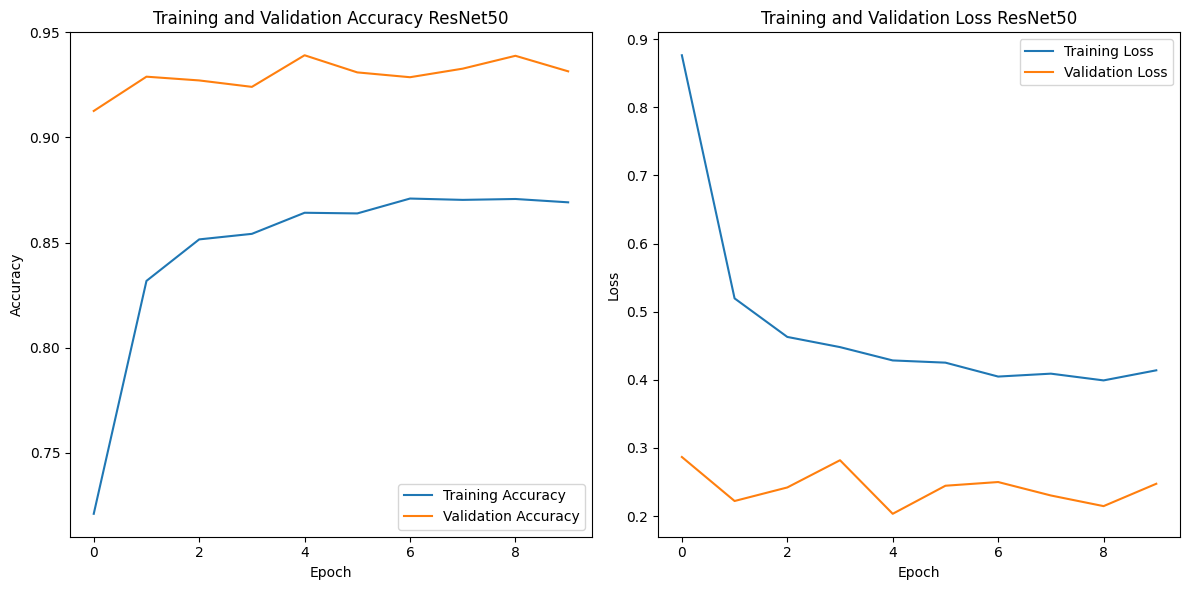

Model ResNet50 saved as ./models/ResNet50_2.keras
Model ResNet101 Summary:


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_13 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101 (Functional)          │ (None, 2048)           │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,678,666 (162.81 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 42,658,176 (162.73 MB)

None
Training Model ResNet101
Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 110s 316ms/step - accuracy: 0.5851 - loss: 1.3777 - val_accuracy: 0.9366 - val_loss: 0.1899
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 90s 302ms/step - accuracy: 0.8410 - loss: 0.5079 - val_accuracy: 0.9429 - val_loss: 0.1830
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 93s 311ms/step - accuracy: 0.8517 - loss: 0.4657 - val_accuracy: 0.9450 - val_loss: 0.1807
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 89s 301ms/step - accuracy: 0.8622 - loss: 0.4349 - val_accuracy: 0.9439 - val_loss: 0.1956
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 90s 301ms/step - accuracy: 0.8671 - loss: 0.4291 - val_accuracy: 0.9490 - val_loss: 0.1759
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 90s 301ms/step - accuracy: 0.8702 - loss: 0.4156 - val_accuracy: 0.9546 - val_loss: 0.1542
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 90s 302ms/step - accuracy: 0.8750 - loss: 0.3901 - val_accuracy: 0.9518 - val_loss: 0.1541
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 90s 302ms/st

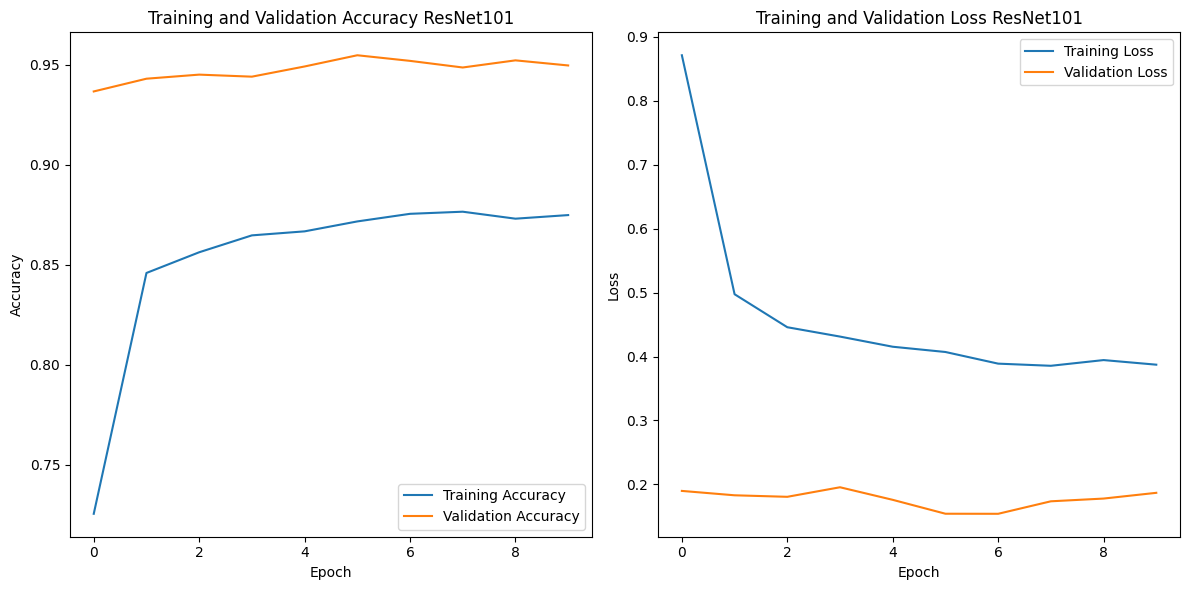

Model ResNet101 saved as ./models/ResNet101_2.keras
Model ResNet152 Summary:


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_15 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152 (Functional)          │ (None, 2048)           │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,391,434 (222.75 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 58,370,944 (222.67 MB)

None
Training Model ResNet152
Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 153s 451ms/step - accuracy: 0.5940 - loss: 1.3369 - val_accuracy: 0.9401 - val_loss: 0.1843
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 128s 430ms/step - accuracy: 0.8357 - loss: 0.5312 - val_accuracy: 0.9483 - val_loss: 0.1676
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 128s 430ms/step - accuracy: 0.8643 - loss: 0.4525 - val_accuracy: 0.9478 - val_loss: 0.1787
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 128s 431ms/step - accuracy: 0.8655 - loss: 0.4303 - val_accuracy: 0.9452 - val_loss: 0.1771
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 128s 431ms/step - accuracy: 0.8667 - loss: 0.4185 - val_accuracy: 0.9541 - val_loss: 0.1539
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 128s 431ms/step - accuracy: 0.8793 - loss: 0.3942 - val_accuracy: 0.9557 - val_loss: 0.1572
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 134s 451ms/step - accuracy: 0.8803 - loss: 0.3869 - val_accuracy: 0.9536 - val_loss: 0.1663
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 128s 4

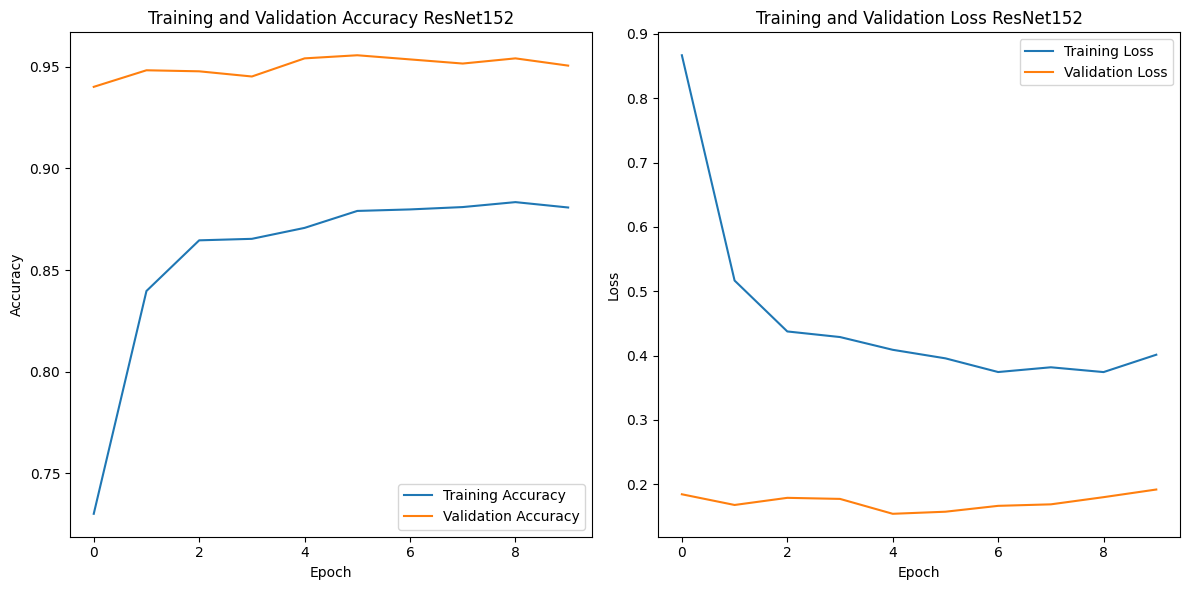

Model ResNet152 saved as ./models/ResNet152_2.keras
Model VGG19 Summary:


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_17 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 512)            │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,029,514 (76.41 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

None
Training Model VGG19
Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 107s 320ms/step - accuracy: 0.3223 - loss: 6.2779 - val_accuracy: 0.8408 - val_loss: 0.8681
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 78s 262ms/step - accuracy: 0.6730 - loss: 1.8449 - val_accuracy: 0.8698 - val_loss: 0.6909
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 78s 261ms/step - accuracy: 0.7152 - loss: 1.3734 - val_accuracy: 0.8869 - val_loss: 0.5610
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 78s 261ms/step - accuracy: 0.7543 - loss: 1.0998 - val_accuracy: 0.8843 - val_loss: 0.5226
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 78s 262ms/step - accuracy: 0.7559 - loss: 0.9744 - val_accuracy: 0.8966 - val_loss: 0.4564
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 78s 262ms/step - accuracy: 0.7533 - loss: 0.9517 - val_accuracy: 0.8828 - val_loss: 0.4916
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 78s 262ms/step - accuracy: 0.7697 - loss: 0.8495 - val_accuracy: 0.9009 - val_loss: 0.4097
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 78s 262ms/step -

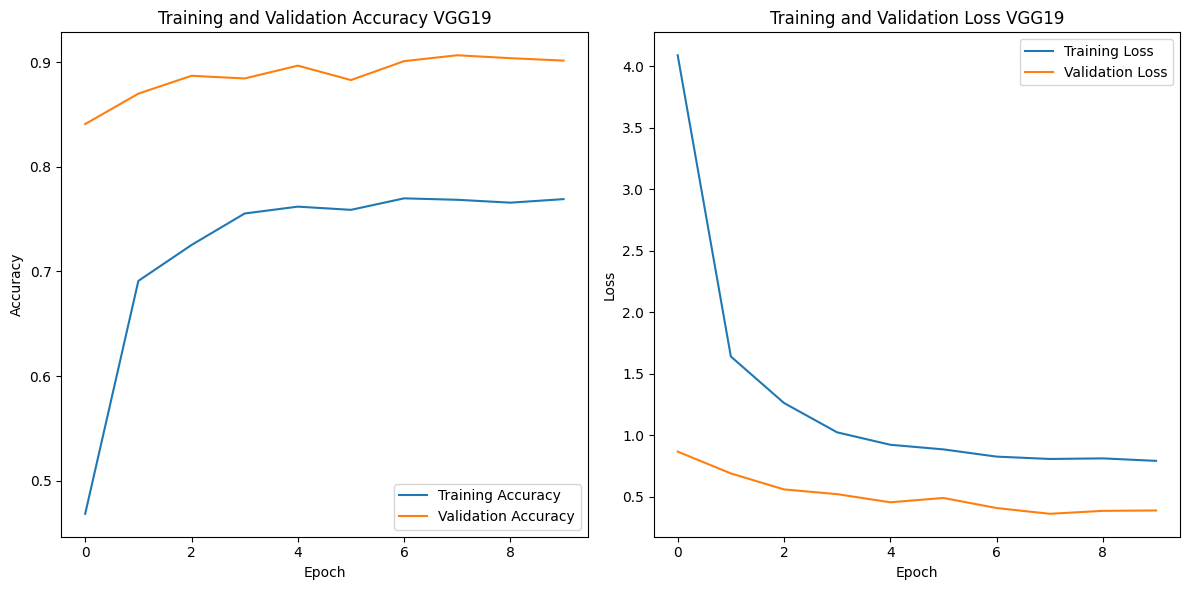

Model VGG19 saved as ./models/VGG19_2.keras
Model VGG16 Summary:


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_19 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Training Model VGG16
Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 68s 224ms/step - accuracy: 0.3305 - loss: 6.3313 - val_accuracy: 0.8454 - val_loss: 0.8678
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 66s 223ms/step - accuracy: 0.6740 - loss: 1.9417 - val_accuracy: 0.8645 - val_loss: 0.7757
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 66s 223ms/step - accuracy: 0.7311 - loss: 1.4145 - val_accuracy: 0.8899 - val_loss: 0.5695
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 67s 224ms/step - accuracy: 0.7454 - loss: 1.1995 - val_accuracy: 0.8968 - val_loss: 0.5107
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 67s 224ms/step - accuracy: 0.7689 - loss: 1.0233 - val_accuracy: 0.8950 - val_loss: 0.4896
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 66s 223ms/step - accuracy: 0.7630 - loss: 0.9190 - val_accuracy: 0.8882 - val_loss: 0.4870
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 84s 229ms/step - accuracy: 0.7780 - loss: 0.8189 - val_accuracy: 0.8915 - val_loss: 0.4712
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 66s 222ms/step - 

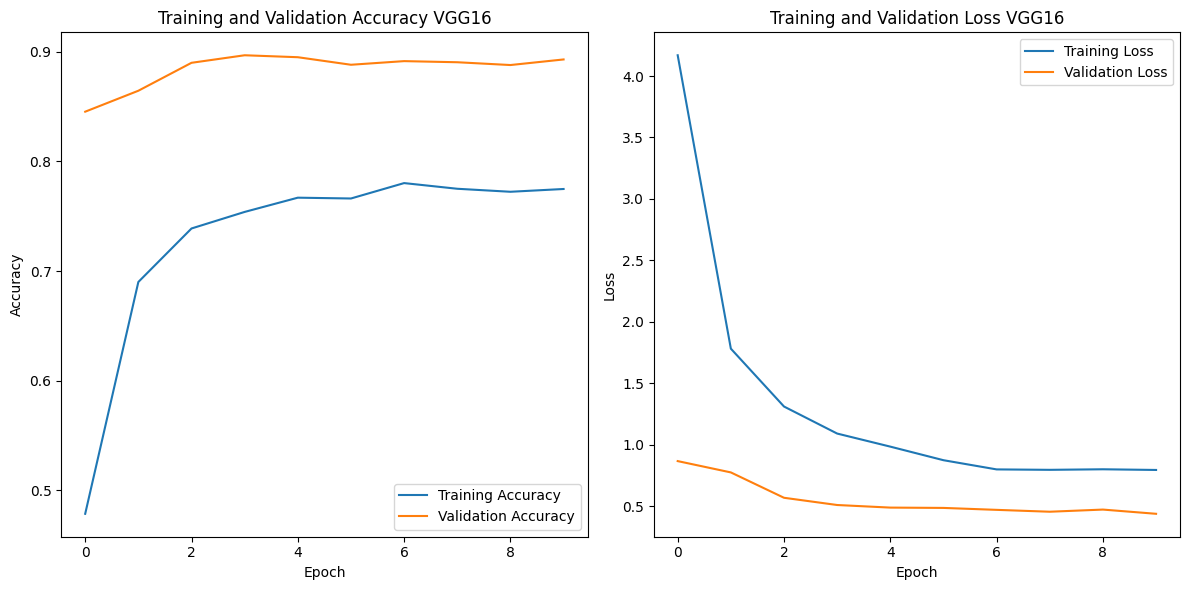

Model VGG16 saved as ./models/VGG16_2.keras
Model EfficientNetB0 Summary:


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_21 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

None
Training Model EfficientNetB0
Epoch 1/10


2024-03-14 21:09:39.002926: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_22_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


296/296 ━━━━━━━━━━━━━━━━━━━━ 51s 125ms/step - accuracy: 0.6584 - loss: 1.1036 - val_accuracy: 0.9753 - val_loss: 0.1389
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 106ms/step - accuracy: 0.8830 - loss: 0.3902 - val_accuracy: 0.9817 - val_loss: 0.0825
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 105ms/step - accuracy: 0.8942 - loss: 0.3334 - val_accuracy: 0.9824 - val_loss: 0.0701
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 106ms/step - accuracy: 0.9004 - loss: 0.3188 - val_accuracy: 0.9850 - val_loss: 0.0601
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 106ms/step - accuracy: 0.9019 - loss: 0.3003 - val_accuracy: 0.9860 - val_loss: 0.0542
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 106ms/step - accuracy: 0.9049 - loss: 0.2835 - val_accuracy: 0.9847 - val_loss: 0.0531
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 106ms/step - accuracy: 0.8998 - loss: 0.3024 - val_accuracy: 0.9847 - val_loss: 0.0520
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 32s 106ms/step - accuracy: 0.9080 - loss: 0.2795 - val

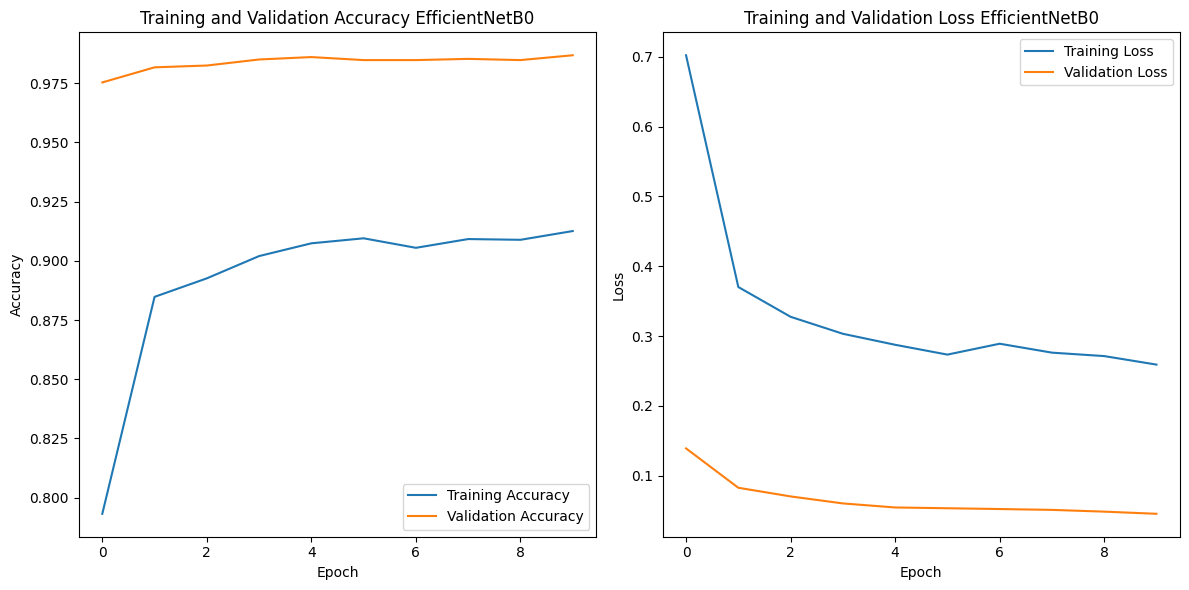

Model EfficientNetB0 saved as ./models/EfficientNetB0_2.keras
Model EfficientNetV2B0 Summary:


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_23 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

None
Training Model EfficientNetV2B0
Epoch 1/10


2024-03-14 21:15:24.815351: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_24_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


296/296 ━━━━━━━━━━━━━━━━━━━━ 45s 107ms/step - accuracy: 0.7286 - loss: 0.9428 - val_accuracy: 0.9916 - val_loss: 0.0700
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 90ms/step - accuracy: 0.9254 - loss: 0.2469 - val_accuracy: 0.9921 - val_loss: 0.0394
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.9279 - loss: 0.2206 - val_accuracy: 0.9934 - val_loss: 0.0305
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.9354 - loss: 0.1961 - val_accuracy: 0.9941 - val_loss: 0.0260
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.9422 - loss: 0.1817 - val_accuracy: 0.9936 - val_loss: 0.0243
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.9402 - loss: 0.1798 - val_accuracy: 0.9946 - val_loss: 0.0222
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.9389 - loss: 0.1768 - val_accuracy: 0.9931 - val_loss: 0.0241
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.9463 - loss: 0.1638 - val_accura

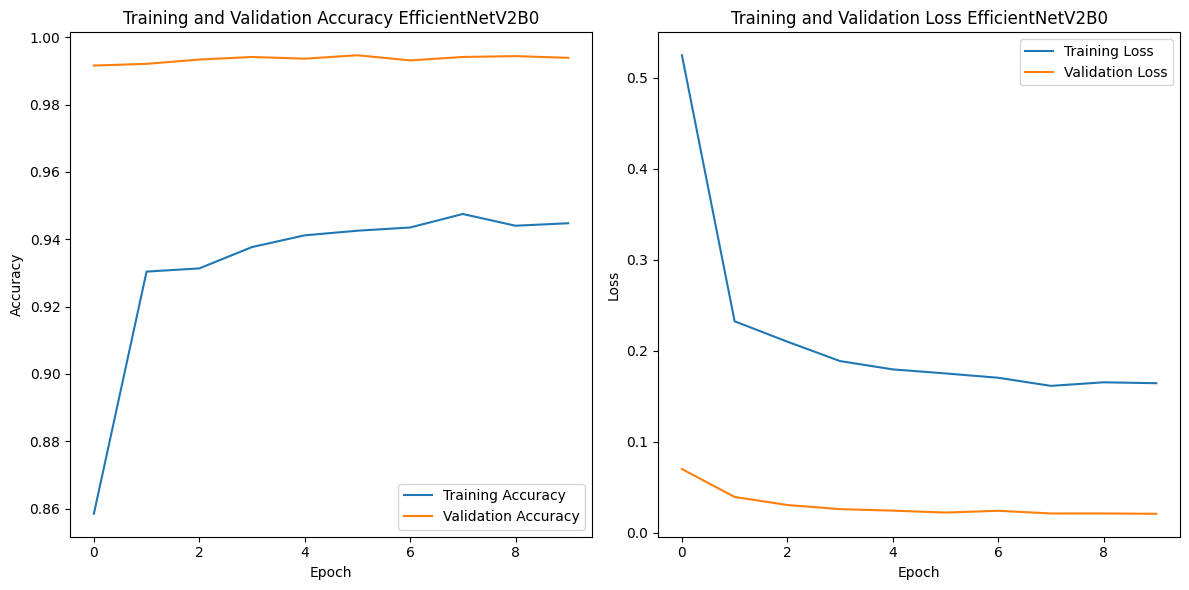

Model EfficientNetV2B0 saved as ./models/EfficientNetV2B0_2.keras
Model EfficientNetV2L Summary:


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_25 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-l (Functional)   │ (None, 1280)           │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,759,658 (449.22 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 117,746,848 (449.17 MB)

None
Training Model EfficientNetV2L
Epoch 1/10


2024-03-14 21:20:51.987502: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_26_1/efficientnetv2-l_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


296/296 ━━━━━━━━━━━━━━━━━━━━ 249s 686ms/step - accuracy: 0.8232 - loss: 0.8110 - val_accuracy: 0.9969 - val_loss: 0.0357
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 187s 630ms/step - accuracy: 0.9597 - loss: 0.1547 - val_accuracy: 0.9969 - val_loss: 0.0227
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 187s 632ms/step - accuracy: 0.9640 - loss: 0.1278 - val_accuracy: 0.9969 - val_loss: 0.0193
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 187s 631ms/step - accuracy: 0.9676 - loss: 0.1171 - val_accuracy: 0.9969 - val_loss: 0.0186
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 187s 631ms/step - accuracy: 0.9670 - loss: 0.1111 - val_accuracy: 0.9967 - val_loss: 0.0181
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 187s 631ms/step - accuracy: 0.9708 - loss: 0.1014 - val_accuracy: 0.9969 - val_loss: 0.0172
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 187s 630ms/step - accuracy: 0.9681 - loss: 0.1020 - val_accuracy: 0.9967 - val_loss: 0.0173
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 188s 632ms/step - accuracy: 0.9708 - loss: 0.09

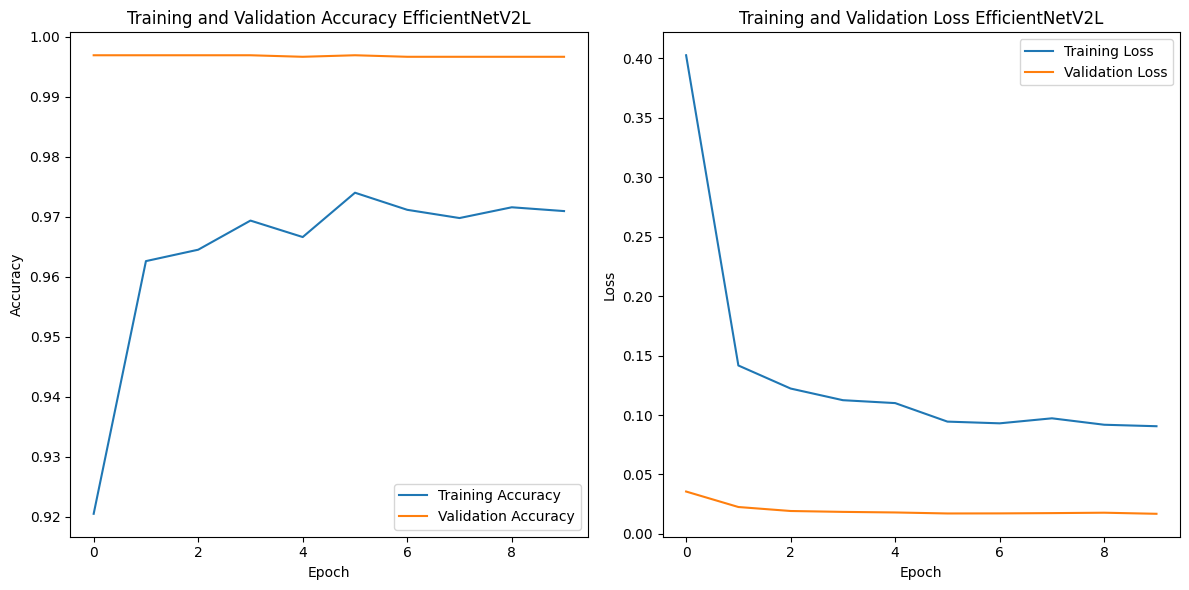

Model EfficientNetV2L saved as ./models/EfficientNetV2L_2.keras
Model DenseNet121 Summary:


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_27 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,047,754 (26.89 MB)

 Trainable params: 10,250 (40.04 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

None
Training Model DenseNet121
Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 89s 235ms/step - accuracy: 0.1990 - loss: 8.1097 - val_accuracy: 0.3169 - val_loss: 3.5700
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - accuracy: 0.3907 - loss: 2.9646 - val_accuracy: 0.2955 - val_loss: 3.1841
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 57s 191ms/step - accuracy: 0.4292 - loss: 2.2172 - val_accuracy: 0.4000 - val_loss: 2.2397
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 57s 192ms/step - accuracy: 0.4684 - loss: 1.9070 - val_accuracy: 0.4031 - val_loss: 2.1648
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 57s 192ms/step - accuracy: 0.4542 - loss: 1.8627 - val_accuracy: 0.3814 - val_loss: 2.3808
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 57s 192ms/step - accuracy: 0.4733 - loss: 1.7953 - val_accuracy: 0.3967 - val_loss: 2.1673
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 57s 192ms/step - accuracy: 0.4686 - loss: 1.8446 - val_accuracy: 0.2634 - val_loss: 3.1426
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 57s 192ms/s

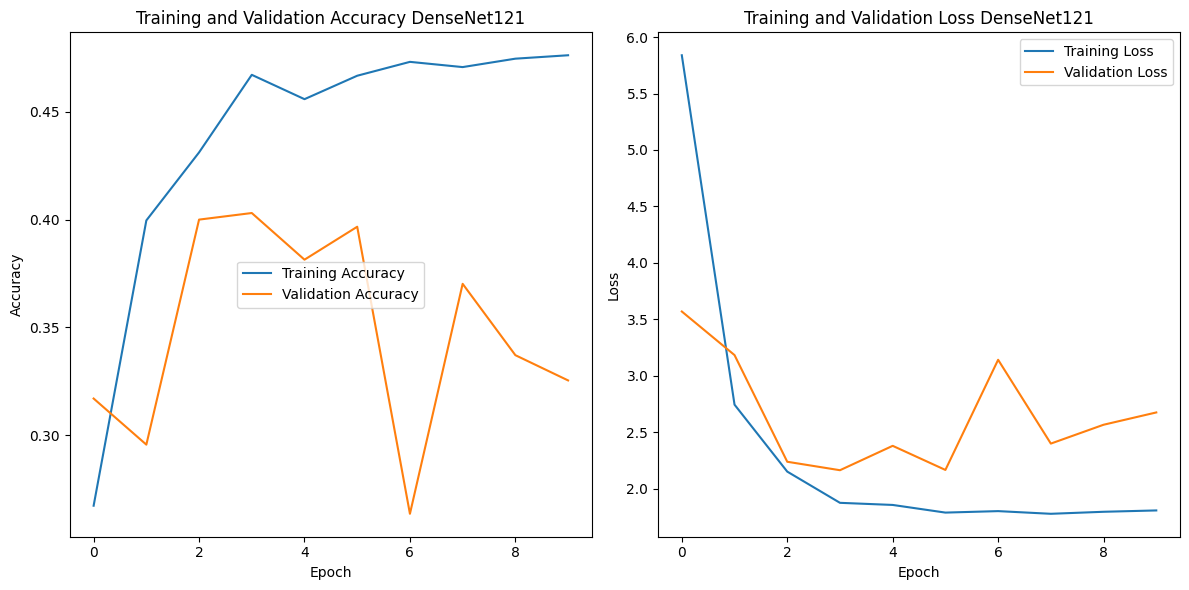

Model DenseNet121 saved as ./models/DenseNet121_2.keras
Model DenseNet169 Summary:


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_29 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 1664)           │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │        16,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,659,530 (48.29 MB)

 Trainable params: 16,650 (65.04 KB)

 Non-trainable params: 12,642,880 (48.23 MB)

None
Training Model DenseNet169
Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 98s 265ms/step - accuracy: 0.2122 - loss: 7.9180 - val_accuracy: 0.3447 - val_loss: 3.6366
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 71s 238ms/step - accuracy: 0.3976 - loss: 3.0184 - val_accuracy: 0.3327 - val_loss: 3.4399
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 77s 260ms/step - accuracy: 0.4362 - loss: 2.4323 - val_accuracy: 0.3083 - val_loss: 3.6567
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 71s 237ms/step - accuracy: 0.4598 - loss: 2.1271 - val_accuracy: 0.2780 - val_loss: 3.7484
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 71s 238ms/step - accuracy: 0.4625 - loss: 2.1007 - val_accuracy: 0.3488 - val_loss: 3.1393
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 71s 237ms/step - accuracy: 0.4663 - loss: 2.0081 - val_accuracy: 0.3822 - val_loss: 2.7549
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 71s 238ms/step - accuracy: 0.4699 - loss: 2.0435 - val_accuracy: 0.3394 - val_loss: 3.1177
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 71s 237ms/s

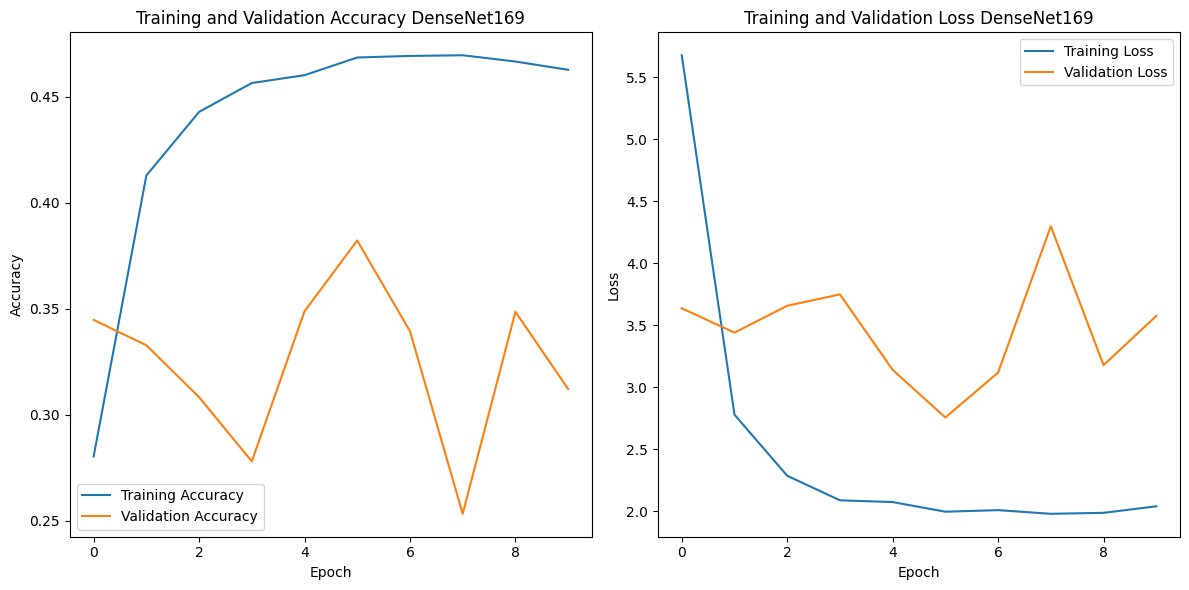

Model DenseNet169 saved as ./models/DenseNet169_2.keras
Model DenseNet201 Summary:


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_31 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 1920)           │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │        19,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,341,194 (69.97 MB)

 Trainable params: 19,210 (75.04 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

None
Training Model DenseNet201
Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 124s 338ms/step - accuracy: 0.2427 - loss: 4.2900 - val_accuracy: 0.3060 - val_loss: 4.3943
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 91s 304ms/step - accuracy: 0.4462 - loss: 1.9804 - val_accuracy: 0.2601 - val_loss: 5.1386
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 90s 303ms/step - accuracy: 0.4945 - loss: 1.6806 - val_accuracy: 0.2831 - val_loss: 4.6750
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 90s 304ms/step - accuracy: 0.4983 - loss: 1.6518 - val_accuracy: 0.2589 - val_loss: 5.2800
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 90s 304ms/step - accuracy: 0.5079 - loss: 1.5859 - val_accuracy: 0.2729 - val_loss: 4.7131
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 90s 304ms/step - accuracy: 0.5160 - loss: 1.5841 - val_accuracy: 0.3014 - val_loss: 4.6951
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 90s 304ms/step - accuracy: 0.5199 - loss: 1.5675 - val_accuracy: 0.2991 - val_loss: 4.5518
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 90s 303ms/

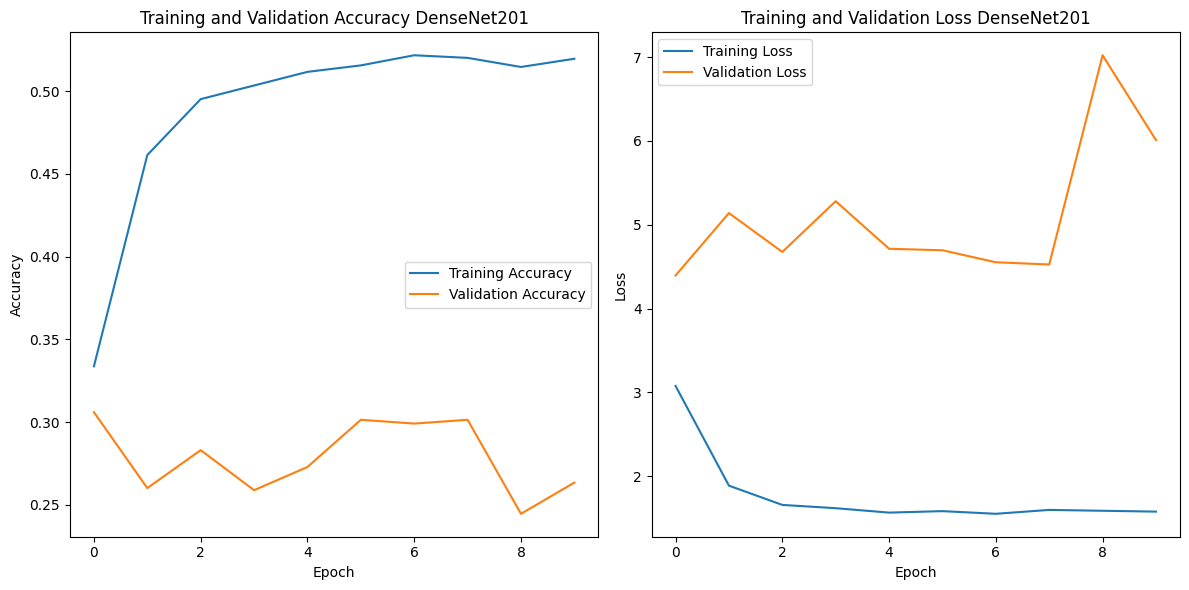

Model DenseNet201 saved as ./models/DenseNet201_2.keras


ResNet50                                  ResNet101                         \
   accuracy      loss val_accuracy  val_loss  accuracy      loss val_accuracy   
0  0.720984  0.876346     0.912611  0.286643  0.725420  0.871025     0.936561   
1  0.831767  0.519459     0.928917  0.222049  0.845813  0.497396     0.942930   
2  0.851515  0.462894     0.927134  0.241933  0.856162  0.445806     0.944968   
3  0.854156  0.447944     0.924076  0.281898  0.864611  0.431184     0.943949   
4  0.864188  0.428382     0.939108  0.203271  0.866617  0.415310     0.949045   
5  0.863872  0.425136     0.930955  0.244466  0.871581  0.407086     0.954650   
6  0.870947  0.404708     0.928662  0.249891  0.875383  0.388880     0.951847   
7  0.870314  0.408974     0.932739  0.230152  0.876439  0.385521     0.948535   
8  0.870736  0.399075     0.938854  0.214531  0.872954  0.394448     0.952102   
9  0.869152  0.413887     0.931465  0.247360  0.874749  0.387254     0.949554   

            ResNet152            ...  DenseNet121           DenseNet169  \
   val_loss  accuracy      loss  ... val_accuracy  val_loss    accuracy   
0  0.189885  0.730067  0.866754  ...     0.316943  3.570008    0.280283   
1  0.183039  0.839687  0.516534  ...     0.295541  3.184098    0.412821   
2  0.180667  0.864611  0.437398  ...     0.400000  2.239736    0.442813   
3  0.195597  0.865350  0.428701  ...     0.403057  2.164824    0.456437   
4  0.175944  0.870736  0.408875  ...     0.381401  2.380756    0.460133   
5  0.154208  0.879079  0.395586  ...     0.396688  2.167307    0.468476   
6  0.154112  0.879818  0.374313  ...     0.263439  3.142639    0.469215   
7  0.173647  0.880980  0.381688  ...     0.370191  2.400560    0.469532   
8  0.177925  0.883409  0.374233  ...     0.337070  2.567382    0.466575   
9  0.186902  0.880769  0.401216  ...     0.325350  2.676326    0.462668   

                                   DenseNet201                         \
       loss val_accuracy  val_loss    accuracy      loss val_accuracy   
0  5.678683     0.344713  3.636601    0.333721  3.077318     0.305987   
1  2.777713     0.332739  3.439929    0.461400  1.887893     0.260127   
2  2.284695     0.308280  3.656654    0.495195  1.658169     0.283057   
3  2.086445     0.277962  3.748439    0.503432  1.619060     0.258853   
4  2.072176     0.348790  3.139345    0.511670  1.566338     0.272866   
5  1.994367     0.382166  2.754853    0.515577  1.583902     0.301401   
6  2.007052     0.339363  3.117670    0.521702  1.552219     0.299108   
7  1.977571     0.253248  4.298777    0.520118  1.598601     0.301401   
8  1.985386     0.348535  3.177340    0.514627  1.588244     0.244586   
9  2.038089     0.312102  3.574620    0.519590  1.578256     0.263439   

             
   val_loss  
0  4.394316  
1  5.138611  
2  4.675008  
3  5.280017  
4  4.713075  
5  4.695135  
6  4.551810  
7  4.525452  
8  7.020821  
9  6.008544  

[10 rows x 44 columns]

DataFrame saved as ./metrics/model_2_history.parquet


In [14]:
# Initialize an empty DataFrame
df = pd.DataFrame()

# Iterate over each model in the list of models
for model_name, base_model in models:
    
    # Define data augmentation pipeline
    data_augmentation = Sequential([
        RandomRotation(0.2),  # Randomly rotate images by up to 20 degrees
        RandomZoom((-0.4, -0.5)),  # Randomly zoom in or out by up to 10%
        RandomFlip('horizontal_and_vertical'),  # Randomly flip images horizontally and vertically
    ])
    
    # Freeze the base model to prevent its weights from being updated during training
    base_model.trainable = False


    model = Sequential(
        [
            Input(shape=(224, 224, 3)),
            data_augmentation,
            base_model,
            Dropout(0.5),
            Dense(10, activation='softmax')
        ]
    )


    model.build(input_shape=(None, 224, 224, 3))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    # Print model summary
    print(f"Model {model_name} Summary:")
    print(model.summary())

    # Save the model architecture as an image
    file_name = f"./architecture/{model_name}_2.png"
    plot_model(model, to_file=file_name, show_shapes=True,show_layer_names=True, show_layer_activations=True, show_trainable=True)
    
    # Train the model
    print(f"Training Model {model_name}")
    
    #Uncomment the following line to train the model in a GPU environment
    # with tf.device('/gpu:0'):
    #    history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)
    
    history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

    # Print final accuracy
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history.get('val_accuracy', None)
    if val_acc:
        val_acc = val_acc[-1]
        print(f"Model {model_name}: Training Accuracy - {train_acc:.4f}, Validation Accuracy - {val_acc:.4f}")
    else:
        print(f"Model {model_name}: Training Accuracy - {train_acc:.4f}")
    
    # Plot training and validation metrics
    print(f"{'='*50} {model_name} {'='*50}")
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss {model_name}')
    plt.legend()

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy {model_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()
        
    # Convert history.history to DataFrame
    model_history = pd.DataFrame(history.history)
    
    # Add a multi-level column with model name
    model_history.columns = pd.MultiIndex.from_product([[model_name], model_history.columns])
    
    # Concatenate model history with existing DataFrame
    df = pd.concat([df, model_history], axis=1)
    
    # Save the trained model
    model_filename = f"./models/{model_name}_2.keras"
    model.save(model_filename)
    print(f"Model {model_name} saved as {model_filename}")

# Display the aggregated DataFrame
display(df)

# Save the DataFrame as a Parquet file
parquet_filename = "./metrics/model_2_history.parquet"
df.to_parquet(parquet_filename)
print(f"DataFrame saved as {parquet_filename}")


All models are saved in `.keras` file after training. Epoch wise model evaluation metrics like `train_accuracy`, `train_loss`, `val_accuracy` and `val_loss` of both experiments are also stored in parquet file to compare models and strategy.